# IMPORTS & SETTINGS

In [62]:
import psycopg2          as pg
import pandas            as pd
import sqlalchemy        as db
import numpy             as np 
import seaborn           as sns 
import matplotlib.pyplot as plt 
import scikitplot        as skplt
import xgboost           as xgb

from sklearn.model_selection  import train_test_split
from sklearn.preprocessing    import MinMaxScaler, StandardScaler 
from IPython.core.display     import HTML
from IPython.display          import Image
from sklearn                  import preprocessing as pp
from sklearn                  import ensemble as en
from sklearn.linear_model     import LogisticRegression
from sklearn                  import neighbors as nh
from sklearn.model_selection  import StratifiedKFold
from scipy                    import stats as ss
from statistics               import quantiles



import pickle
import json
import requests

## Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline   
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 20
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()


def cross_validation (model_name, model_cv, xtraining, kfold=5, verbose = False ):
    """StratifiedKFolds cross-validation. 
       - xtraining uses df_train already transformed. FOR A FINAL VERSION, a function to deal with transformation will be built  
       - pass a model_cv that has not fitted yet
    """
    skfold = StratifiedKFold(n_splits=kfold)

    # Split X, y    
    sk_x = xtraining.values.copy() # predictor variables. All columns included, so the 'id' and 'response' will be refered after skfold split
    sk_y = xtraining['response'].values.copy() # response variable

    # list that will take the error calculation of each iteration    
    list_precision = [] 
    list_recall = []

    for i,(train_index, validation_index) in enumerate (skfold.split(sk_x,sk_y)):
    # train_index and validation_index refers to the index at train dataset (at this CRISP, already transformed)

        #parameters
        all_columns = ['id', 'age', 'region_code', 'policy_sales_channel', 'driving_license',
                        'vehicle_age', 'vehicle_damage', 'previously_insured', 'annual_premium',
                        'vintage', 'response', 'gender_Female', 'gender_Male']

        cols_selected = ['vintage','annual_premium','age','policy_sales_channel','region_code', 'vehicle_damage','previously_insured']

        # reset these variables
        df_x_train = pd.DataFrame()
        df_x_validation = pd.DataFrame()

       
        # Separating the train and validation by index
        x_train_cv, y_train_cv = sk_x[train_index], sk_y [train_index]
        x_validation_cv, y_validation_cv = sk_x[validation_index], sk_y[validation_index]

        
        # Concating empty dataframe with splited subsets(arrays), so columns can be manualy selected from a list. 
        df_x_train = pd.concat([df_x_train, pd.DataFrame(x_train_cv,columns=all_columns)],axis=1) 
        df_x_validation = pd.concat([df_x_validation, pd.DataFrame(x_validation_cv,columns=all_columns)],axis=1)
        # obs. as df is mutable, i thought it was bad ideia to attribute to df_x_ the df of x_.._cv directly. 
        
        # Selecting the features 
        x_train_cv = df_x_train[cols_selected].values
        x_validation_cv = df_x_validation[cols_selected].values

        # Instancing the model
        # knn_model_cv = nh.KNeighborsClassifier (n_neighbors = 2)

        # Fiting with train subset 
        model_cv.fit (x_train_cv, y_train_cv)

        # Predicting Proba
        yhat_cv = model_cv.predict_proba (x_validation_cv)

        
        ### CRISP 2 ### 
        # function to prepare the data and deliver these metrics 
        
        # adding column 'score' to df_x_validation 
        df_x_validation['score'] = yhat_cv[:,1].tolist()

        # Sorting values by score
        df_x_validation = df_x_validation.sort_values('score', ascending = False).reset_index(drop=True)

        # precision at k 
        precision_at_100 = precision_at_k(df_x_validation, 100)

        # recall at k 
        recall_at_100 = recall_at_k(df_x_validation, 100)

        # criar lista para receber cada precision e recall das iteracoes; dispor em dicionario 
        list_precision.append (precision_at_100)
        list_recall.append (recall_at_100)


    return pd.DataFrame( {'model_name':model_name,
                          'kfold':kfold,
                          'precision_at_k':np.round(np.mean(list_precision),4),
                          'recall_at_k':np.round(np.mean(list_recall),4)}, index=[0] )



def precision_at_k (data, k=2000):

    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k,'precision_at_k']




def recall_at_k (data, k=2000):

    data['recall_at_k'] = data['response'].cumsum() / sum(data['response'])

    return data.loc[k,'recall_at_k']


def cramer_v (x,y):

    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape

    # chi2 
    chi2 = ss.chi2_contingency(cm)[0] 
    chi2corr = max(0, chi2 - (k-1)* (r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt ( (chi2corr/n) / (min (kcorr-1 , rcorr-1)))
    

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# DATA COLLECTION

## Database Connection

In [3]:
# credentials
dbname = 'comunidadedsdb'
user = 'member'
password = 'cdspa'
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432

In [90]:
#Connect to comunidadedsdb

def db_connection(dbname, user, password, host, port):
    conn = pg.connect(dbname = dbname,
                            user = user,
                            password = password,
                            host = host,
                            port = port)
    return conn
    

## Schema Query

In [91]:
conn = db_connection(dbname, user, password, host, port)

In [6]:
#creating a cursor
cursor = conn.cursor()

#query to list the schemas
query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace
"""

#execution with cursor
cursor.execute (query_schema)

#colecting the data e closing cursor and connection
record = cursor.fetchall()
cursor.close()
conn.close()

In [7]:
record

[('pg_toast',),
 ('pg_temp_1',),
 ('pg_toast_temp_1',),
 ('pg_catalog',),
 ('information_schema',),
 ('public',),
 ('pa004',),
 ('pg_temp_4',),
 ('pg_toast_temp_4',),
 ('pa005',),
 ('pg_temp_9',),
 ('pg_toast_temp_9',)]

## Tables Query 

In [14]:
conn = db_connection(dbname, user, password, host, port)

In [95]:
cursor = conn.cursor()

query_tables = """
    SELECT tablename
    FROM pg_tables
    WHERE schemaname='pa004'
"""

cursor.execute (query_tables)

record = cursor.fetchall ()
print(record)

cursor.close()
conn.close()



[('users',), ('vehicle',), ('insurance',)]


## Collecting Data using Psycopg2

In [17]:
conn = db_connection(dbname, user, password, host, port)

In [18]:
cursor = conn.cursor()

query_tables_users = """
    SELECT *
    FROM pa004.users u 
    WHERE u.age > 44
"""

cursor.execute (query_tables_users)

record = cursor.fetchall ()
print(record)

cursor.close()
conn.close()



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
data = pd.DataFrame(record)

data.head()

,0,1,2,3,4
0,2,Male,76,3.0,26.0
1,3,Male,47,28.0,26.0
2,8,Female,56,28.0,26.0
3,11,Female,47,35.0,124.0
4,14,Male,76,28.0,13.0


## Collecting data using SQLAlchemy

In [4]:
query_tables_joined = """
    SELECT *
    FROM pa004.users u LEFT JOIN pa004.vehicle v ON (u.id = v.id)
                       LEFT JOIN pa004.insurance i ON (u.id = i.id)
"""

In [93]:
# Deprecated method

# df = pd.read_sql (query_tables_joined, conn)
# df = df.drop(df.columns[[5,9]], axis=1)
# df.head()

In [5]:
# Using sqlachemy and pandas

string_connect = 'postgresql://' + user + ':' + password + '@' + host + ':' + str(port) + '/' + dbname
engine = db.create_engine(string_connect)
conn1 = engine.connect()
df = pd.read_sql(query_tables_joined, conn1)
df.head()


,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


In [8]:
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/data/interim/data_collection.csv'

df.to_csv(path, index=False)

# DATA DESCRIPTION
**Step 1 - CRISP**

In [3]:
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/data/interim/data_collection.csv'

df1 = pd.read_csv(path)

# # Droping repetead columns 'id' 
df1 = df1.drop(columns=['id.1','id.2'])

df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


## Columns description !!! translate to English

|Column|Description|
|:------|:-----------|
|Id| Unique identifier|
|Gender|gênero do cliente.|
|Age| idade do cliente.|
|Driving License| 0, o cliente não tem permissão para dirigir e 1, o cliente tem para dirigir ( CNH – CarteiraNacional de Habilitação)|
|Region Code| código da região do cliente.|
|Previously Insured| 0, o cliente não tem seguro de automóvel e 1, o cliente já tem seguro de automóvel.
|Vehicle Age| idade do veículo.|
|Vehicle Damage| 0, cliente nunca teve seu veículo danificado no passado e 1, cliente já teve seu veículo danificado no passado.|
|Anual Premium| quantidade que o cliente pagou à empresa pelo seguro de saúde anual.|
|Policy sales channel| código anônimo para o canal de contato com o cliente.|
|Vintage| número de dias que o cliente se associou à empresa através da compra do seguro de saúde.|
|Response| 0, o cliente não tem interesse e 1, o cliente tem interesse.|

## Data dimensions


In [4]:
print('Number of rows:{}'.format(df1.shape[0]))
print('Number of columns:{}'.format(df1.shape[1]))

Number of rows:381109
Number of columns:12


## Data Types

In [5]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## Change Dtypes

In [6]:
df1['region_code'] = df1['region_code'].astype('int64')
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')

In [7]:
# -----
# Ha dados numericos categoricos como region_code, policy_sales_channel, driving license, previosly insured e response 
# 

## Check NA 

In [8]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## Descriptive Statistical

In [9]:
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11,152,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15,14,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35,152,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8,160,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8,124,1,1-2 Year,Yes,0,42297.0,264,0


In [10]:
num_attributes = df1[['annual_premium','vintage','age']] 
cat_attributes = df1.drop(['annual_premium','vintage','age'], axis=1)

### Numerical Attributes 

In [11]:
# Central tendency
ctd1 = pd.DataFrame(num_attributes.apply(np.mean))
ctd2 = pd.DataFrame(num_attributes.median())

# Dispersion tendency
d1 = pd.DataFrame(num_attributes.apply(np.std))
d2 = pd.DataFrame(num_attributes.apply(np.min))
d3 = pd.DataFrame(num_attributes.apply(np.max))
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()- x.min(), axis=0))
d5 = pd.DataFrame(num_attributes.skew())
d6 = pd.DataFrame(num_attributes.kurtosis())

# Merge
m1 = pd.concat([ctd1, ctd2, d1, d2, d3, d4, d5,d6],axis=1)
m1.columns = ['mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']
m1


,mean,median,std,min,max,range,skew,kurtosis
annual_premium,30564.389581,31669.0,17213.132474,2630.0,540165.0,537535.0,1.766087,34.004569
vintage,154.347397,154.0,83.671194,10.0,299.0,289.0,0.003030,-1.200688
age,38.822584,36.0,15.511591,20.0,85.0,65.0,0.672539,-0.565655


#### vintage

#### annual_premium

<AxesSubplot: ylabel='Count'>

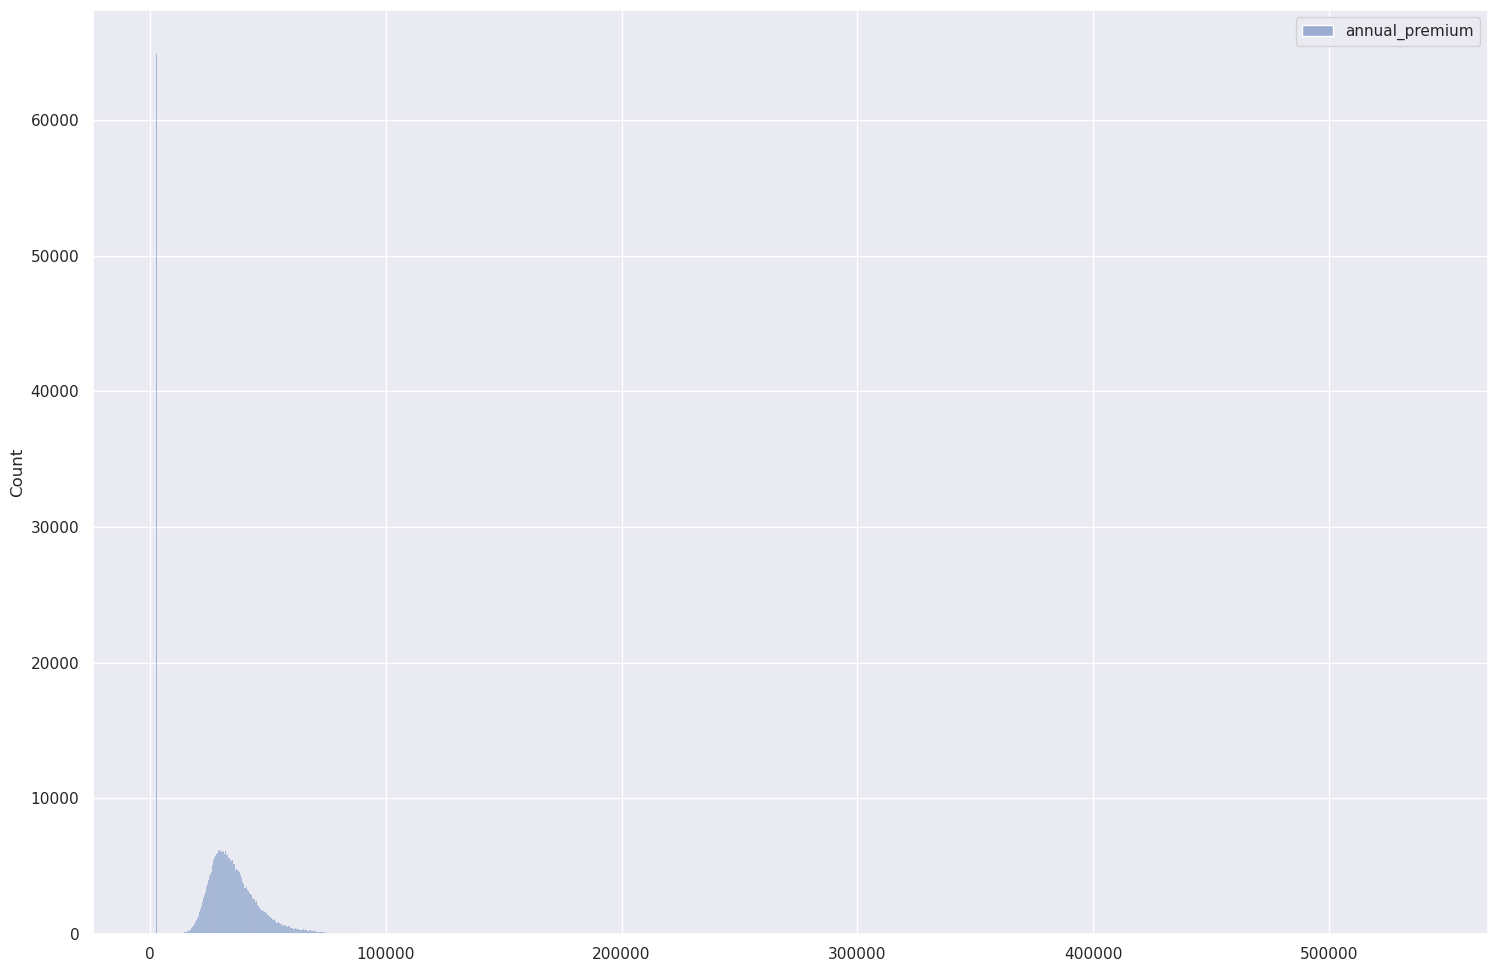

In [12]:
sns.histplot(data=df1[['annual_premium']])

Annual premium has almost a normal distribuition, except by outliers at left side of the curve

<AxesSubplot: ylabel='Count'>

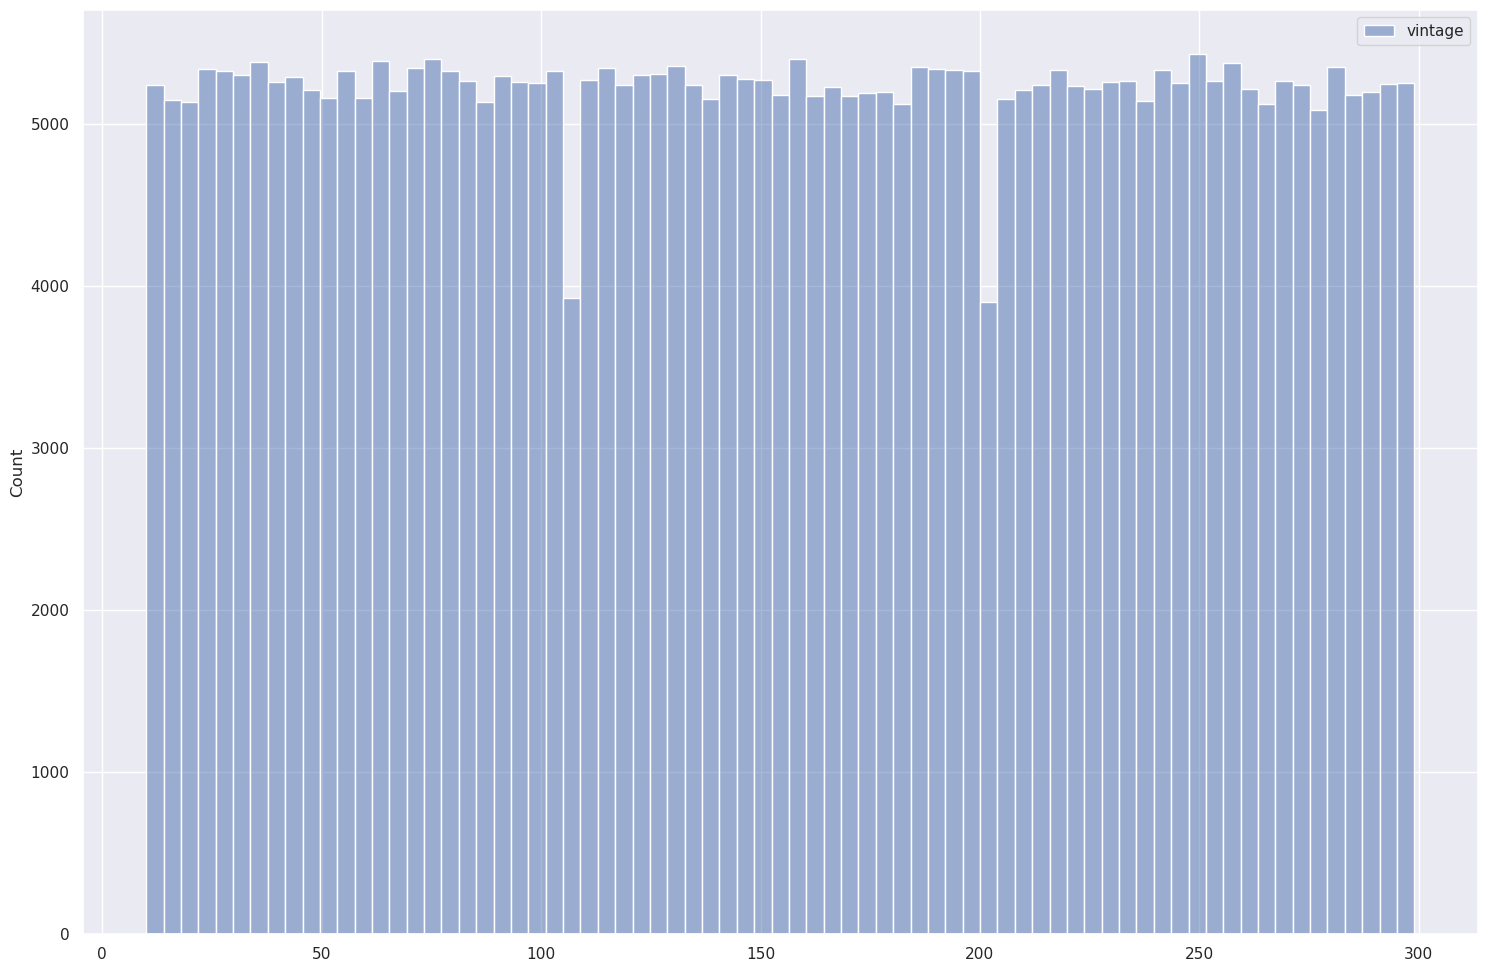

In [13]:
sns.histplot(data=df1[['vintage']])

This feature indicates how much time since the customer acquired the health insurance and it can indicates uniformity of sales pipeline. At this case, there is no relevant variability 

#### age

<AxesSubplot: ylabel='Count'>

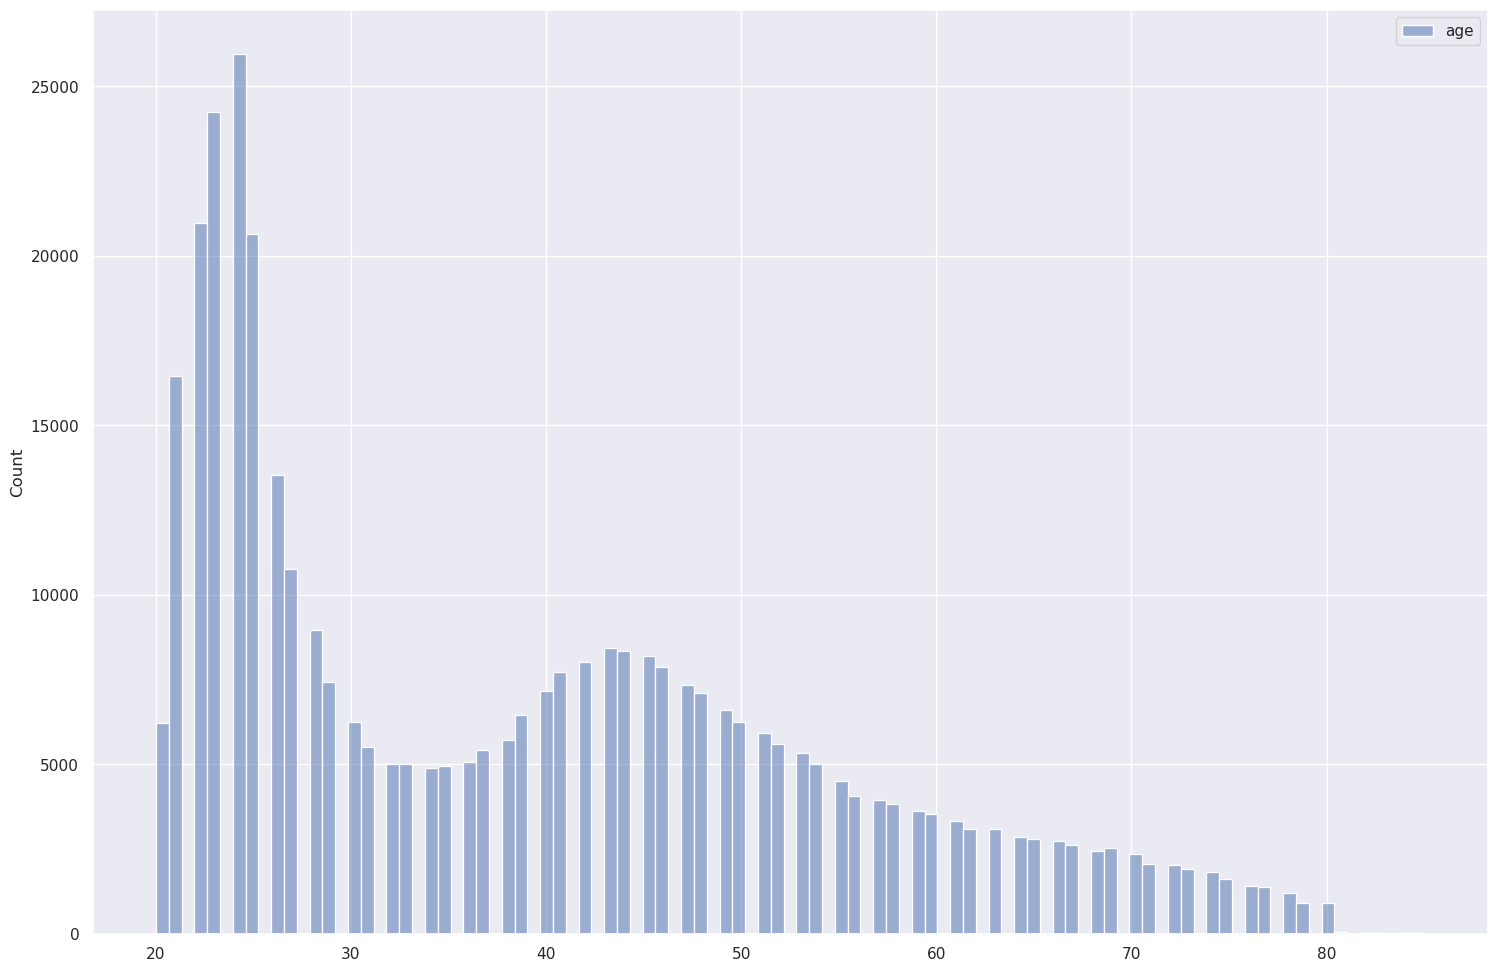

In [14]:
sns.histplot(df1[['age']])

In [15]:
aux1 = df1.copy()

aux1['age_group'] = df1['age'].apply(lambda x: '20-30' if (x>=20) & (x<30) else
                             '30-40' if (x>=30) & (x<40) else
                             '40-50' if (x>=40) & (x<50) else
                             '50-60' if (x>=50) & (x<60) else
                             '60-70' if (x>=60) & (x<70) else
                             '70-80' if (x>=70) & (x<80) else '80+')

aux1 = aux1[['id','age_group']].groupby('age_group').count().reset_index()
aux1['frequency'] = aux1['id']/sum(aux1['id'])
aux1.head()

,age_group,id,frequency
0,20-30,155203,0.407240
1,30-40,54253,0.142356
2,40-50,76846,0.201638
3,50-60,48034,0.126037
4,60-70,29023,0.076154


There is two intervals that concentrate most of the data. Between 20-30 years old and between 40-50, where 60% of data is placed



### Categorical Attributes

In [16]:
cat_attributes.apply(lambda x: x.unique())

id                      [7, 13, 18, 31, 39, 55, 73, 79, 95, 108, 114, ...
gender                                                     [Male, Female]
region_code             [11, 15, 35, 8, 28, 39, 29, 30, 25, 22, 36, 0,...
policy_sales_channel    [152, 14, 160, 124, 13, 26, 151, 157, 156, 122...
driving_license                                                    [1, 0]
vehicle_age                               [< 1 Year, 1-2 Year, > 2 Years]
vehicle_damage                                                  [Yes, No]
previously_insured                                                 [0, 1]
response                                                           [0, 1]
dtype: object

In [23]:
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/data/interim/data_description.csv'

df1.to_csv(path, index=False)

# FEATURE ENGINEERING
**Step 2 - CRISP**

In [30]:
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/data/interim/data_description.csv'

df2 = pd.read_csv(path)


## Mental map of hypothesis

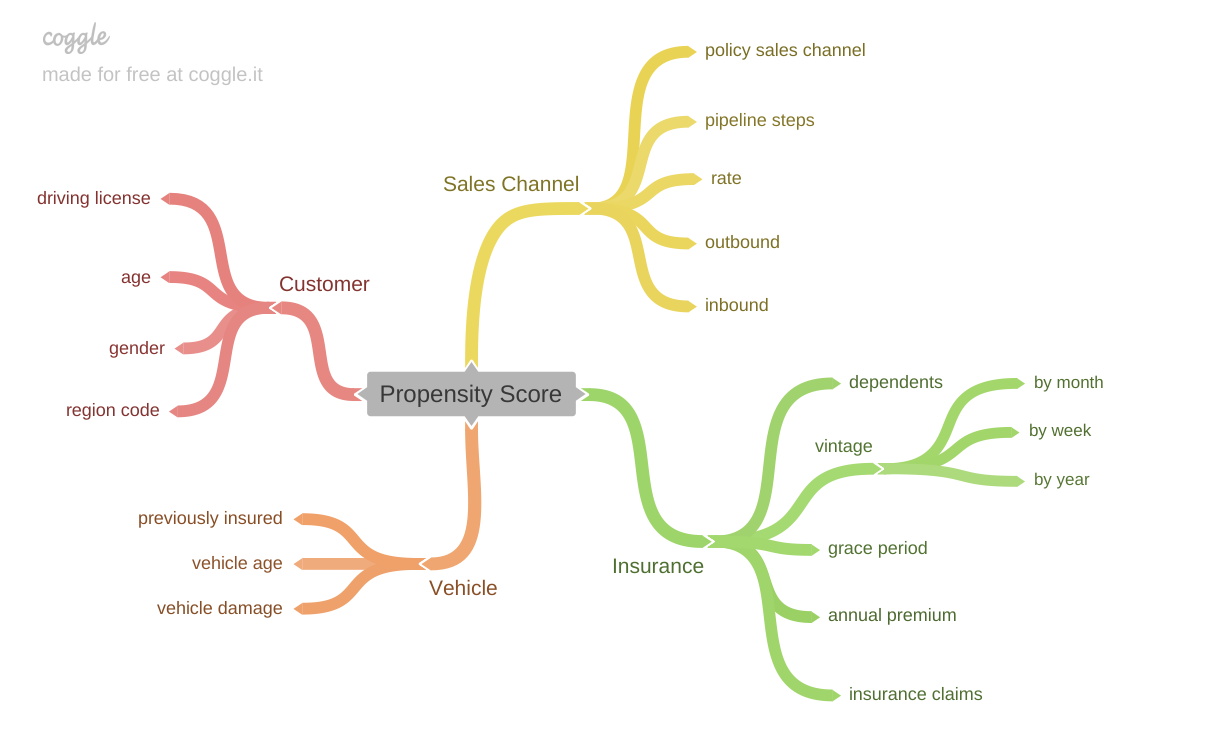

In [69]:
Image ('/home/daniel/repos/pa04_health_insurance_cross_sell/img/MindMapHypothesis.png')


## Creating hypothesis

### Sales Channel 

1. Outbound channels has greater interest than inbound
2. The sales channels with more interested has the best rates

### Customer

1. Interest is greater at customers older than 40 years old 
2. Interest is greater within woman 
3. Region with high ratio of interested have higher ratio of older people
4. Less than 10% of interested does not have driving license

### Vehicle

1. Interest rate is greater on newer vehicles
2. Interest rate is greater when vehicle has already damaged

### Insurance

1. Interest is greater within insurance vintage with more than 6 months
2. Interest is greater within annual premmium above 30k
3. Interest is lower within early 2 weeks customers
4. Interest is lower among customers in grace period
5. Interest is greater within customers with dependents
6. Interest is greater within customers that have already insurance claims
7. Interest is greater among those who do not have previously insurance

### Final List of Hypothesis


1. The sales channels with more interested has the best rates
2. Interest is greater at customers older than 40 years old
3. Interest is greater within woman
4. Interest rate is greater on newer vehicles
5. Interest rate is greater when vehicle has already damaged
6. Interest is greater within insurance vintage with more than 6 months
7. Interest is greater within annual premmium above 30k
8. Region with high ratio of interested have higher ratio of older people 
9. Less than 10% of interested does not have driving license
10. Interest is greater among those who do not have previously insurance


## Feature Engineering

In [31]:
# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# vintage 
df2['vintage_by_week'] = df2['vintage'].apply(lambda x: x/7).astype(int)
df2['vintage_by_month'] = df2['vintage'].apply(lambda x: x/30).astype(int)

# age_group 
df2['age_group'] = df2['age'].apply(lambda x: '20-30' if (x>=20) & (x<30) else
                             '30-40' if (x>=30) & (x<40) else
                             '40-50' if (x>=40) & (x<50) else
                             '50-60' if (x>=50) & (x<60) else
                             '60-70' if (x>=60) & (x<70) else
                             '70-80' if (x>=70) & (x<80) else '80+')

# premium_above_medium_age_group
aux1 = df2.groupby('age_group')['annual_premium'].median()
df2['above_medium'] = df2['age_group'].map(aux1)
df2['above_medium'] = df2.apply(lambda x: 1 if x['annual_premium']>x['above_medium'] else 0, axis=1)
df2 = df2.rename({'above_medium':'premium_above_medium_age_group'}, axis=1)

In [33]:
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/data/interim/feature_engineering.csv'

df2.to_csv(path, index=False)

# FEATURE FILTERING
**Step 3 - CRISP**

In [34]:
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/data/interim/feature_engineering.csv'

df3 = pd.read_csv(path)


In [36]:
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/data/interim/feature_filtering.csv'

df3.to_csv(path, index=False)

# EXPLORATORY DATA ANALYSIS
**Step 4 - CRISP**

In [5]:
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/data/interim/feature_filtering.csv'

df4 = pd.read_csv(path)

In [4]:
df4.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,vintage_by_week,vintage_by_month,age_group,premium_above_medium_age_group
0,7,Male,23,11,152,1,< 1 Year,1,0,23367.0,249,0,35,8,20-30,0
1,13,Female,41,15,14,1,1-2 Year,0,1,31409.0,221,0,31,7,40-50,0
2,18,Female,25,35,152,1,< 1 Year,0,1,46622.0,299,0,42,9,20-30,1
3,31,Female,26,8,160,1,< 1 Year,0,0,2630.0,136,0,19,4,20-30,0
4,39,Male,45,8,124,1,1-2 Year,1,0,42297.0,264,0,37,8,40-50,1


## Univariate Analysis

### Response Variable

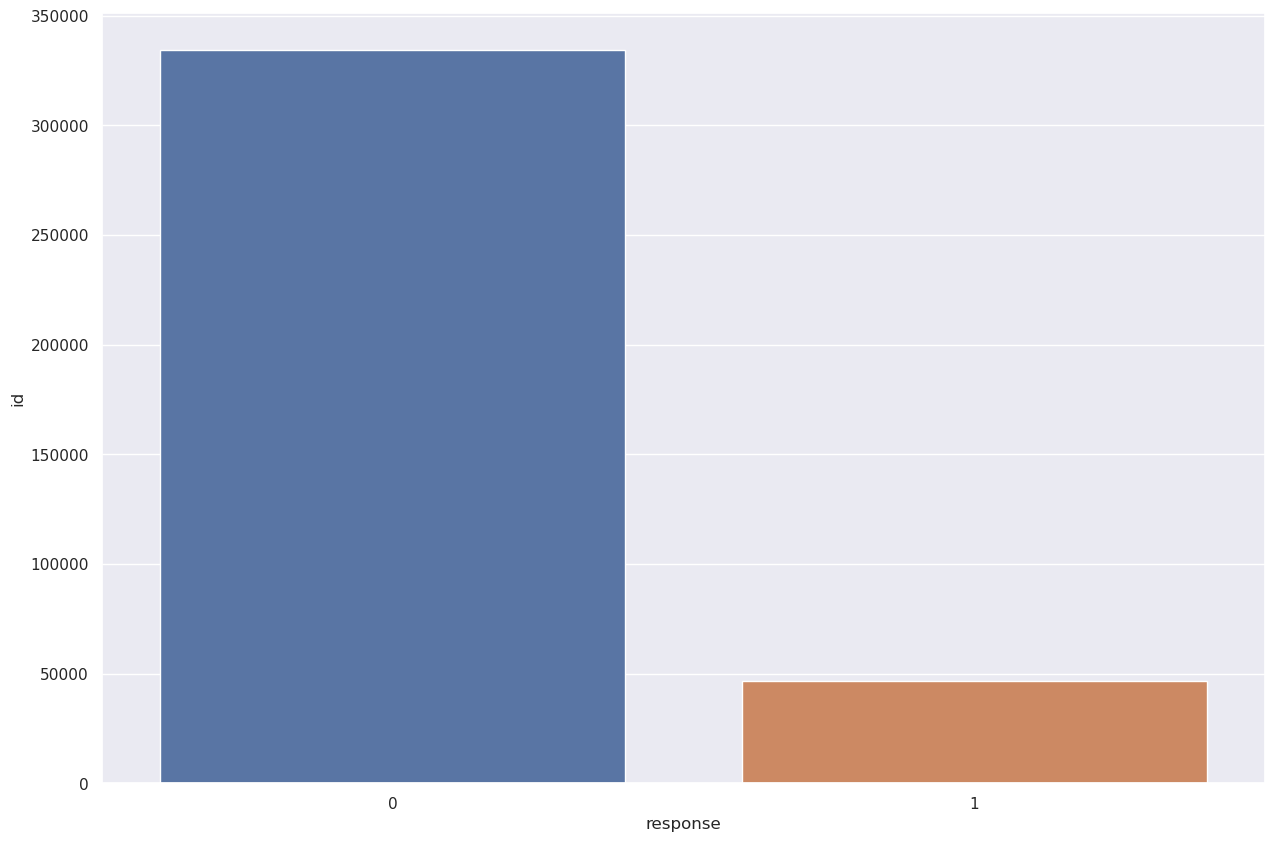

In [75]:
aux1 = df4[['response', 'id']].groupby('response').count().reset_index()
sns.barplot(data=aux1, x= 'response', y= 'id');

In [76]:
aux1['frequency'] = aux1['id']/sum(aux1['id'])
aux1

,response,id,frequency
0,0,334399,0.877437
1,1,46710,0.122563


The frequency of positive responses is 12.25%, and show how unbalanced our data is 

### Numerical Variable

In [6]:
num_attributes = df4[['annual_premium','vintage','vintage_by_week','vintage_by_month','age']] 

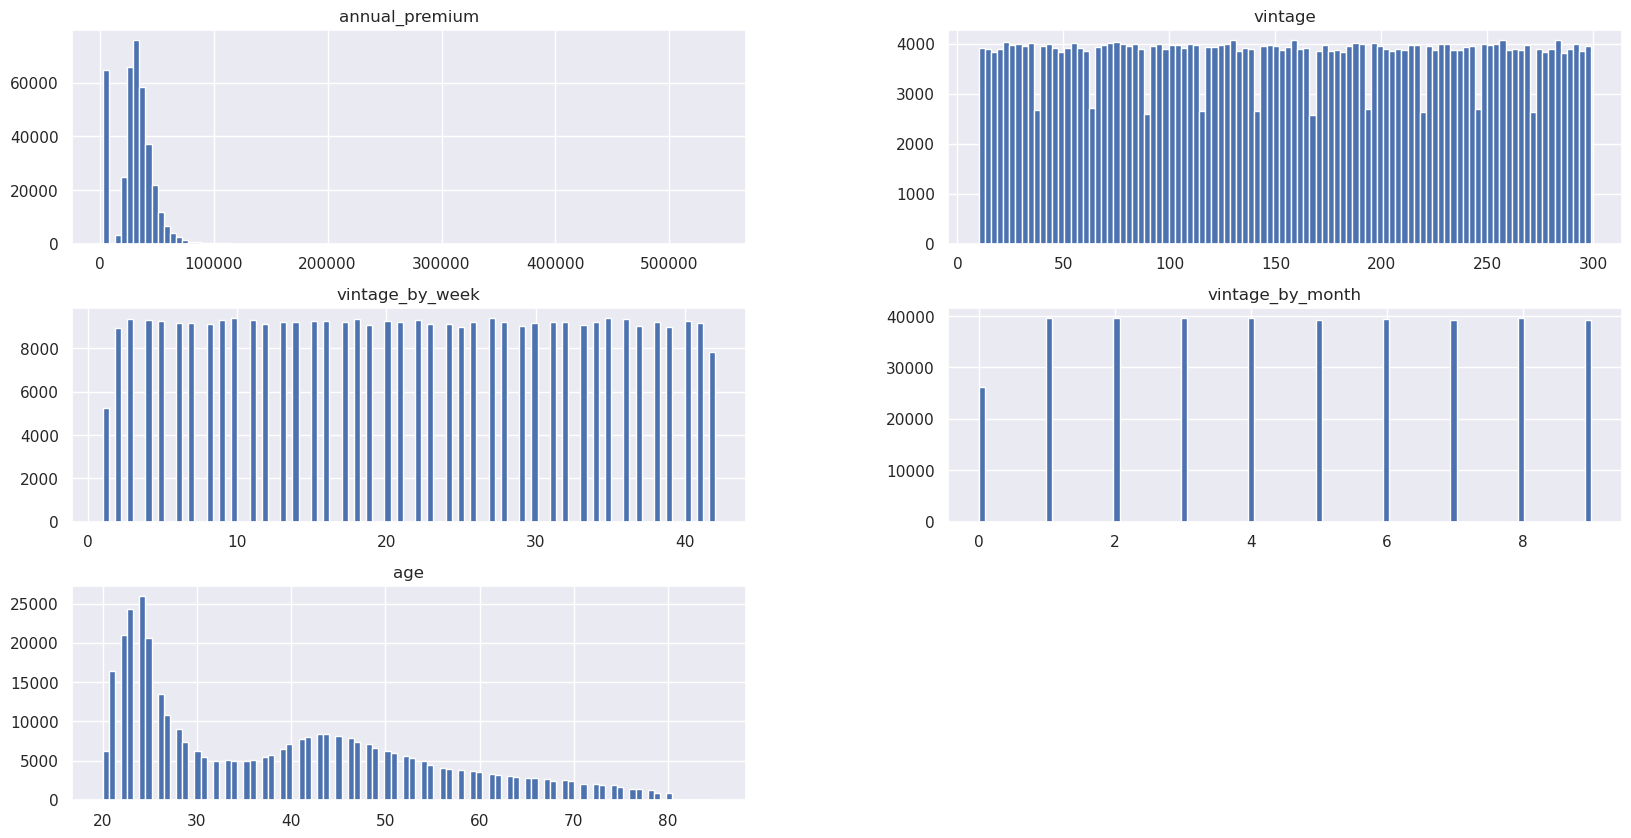

In [172]:
num_attributes.hist (bins=100);

### Categorical Variable

In [7]:
cat_attributes = df4.drop(['annual_premium','vintage','vintage_by_week','vintage_by_month','age', 'id', 'response'], axis=1)

cat_attributes.apply(lambda x: x.unique())

gender                                                               [Male, Female]
region_code                       [11, 15, 35, 8, 28, 39, 29, 30, 25, 22, 36, 0,...
policy_sales_channel              [152, 14, 160, 124, 13, 26, 151, 157, 156, 122...
driving_license                                                              [1, 0]
vehicle_age                                         [< 1 Year, 1-2 Year, > 2 Years]
vehicle_damage                                                               [1, 0]
previously_insured                                                           [0, 1]
age_group                           [20-30, 40-50, 30-40, 50-60, 60-70, 70-80, 80+]
premium_above_medium_age_group                                               [0, 1]
dtype: object

#### policy_sales_channel

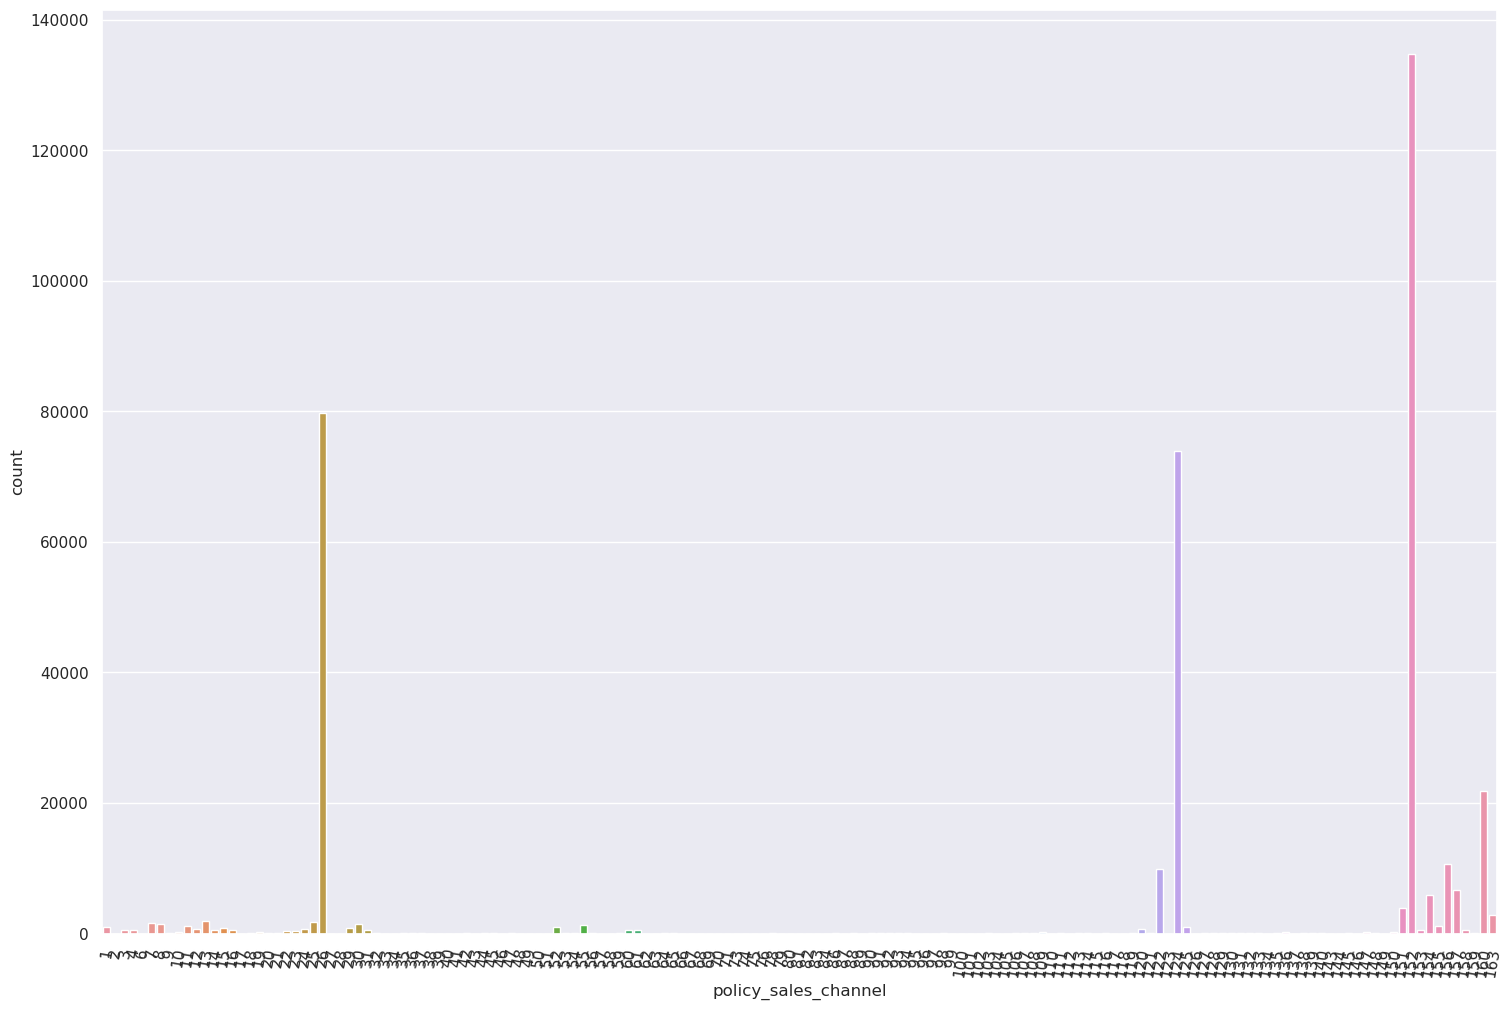

In [17]:
# policy_sales_channel
sales_channel = df4[['policy_sales_channel','id']].groupby('policy_sales_channel').count().reset_index()
sales_channel.columns = ['policy_sales_channel','count']
sns.barplot(data=sales_channel, x = 'policy_sales_channel',y='count')
plt.xticks(rotation = 80);

In [18]:
sales_channel['frequency'] = sales_channel['count']/sum(sales_channel['count'])
sales_channel = sales_channel.sort_values('frequency', ascending = False)
sales_channel.head(5)

,policy_sales_channel,count,frequency
145,152,134784,0.353663
24,26,79700,0.209127
119,124,73995,0.194157
153,160,21779,0.057146
149,156,10661,0.027974


The 5 most frequent channel concentrate almost 85% of the rows

#### region_code

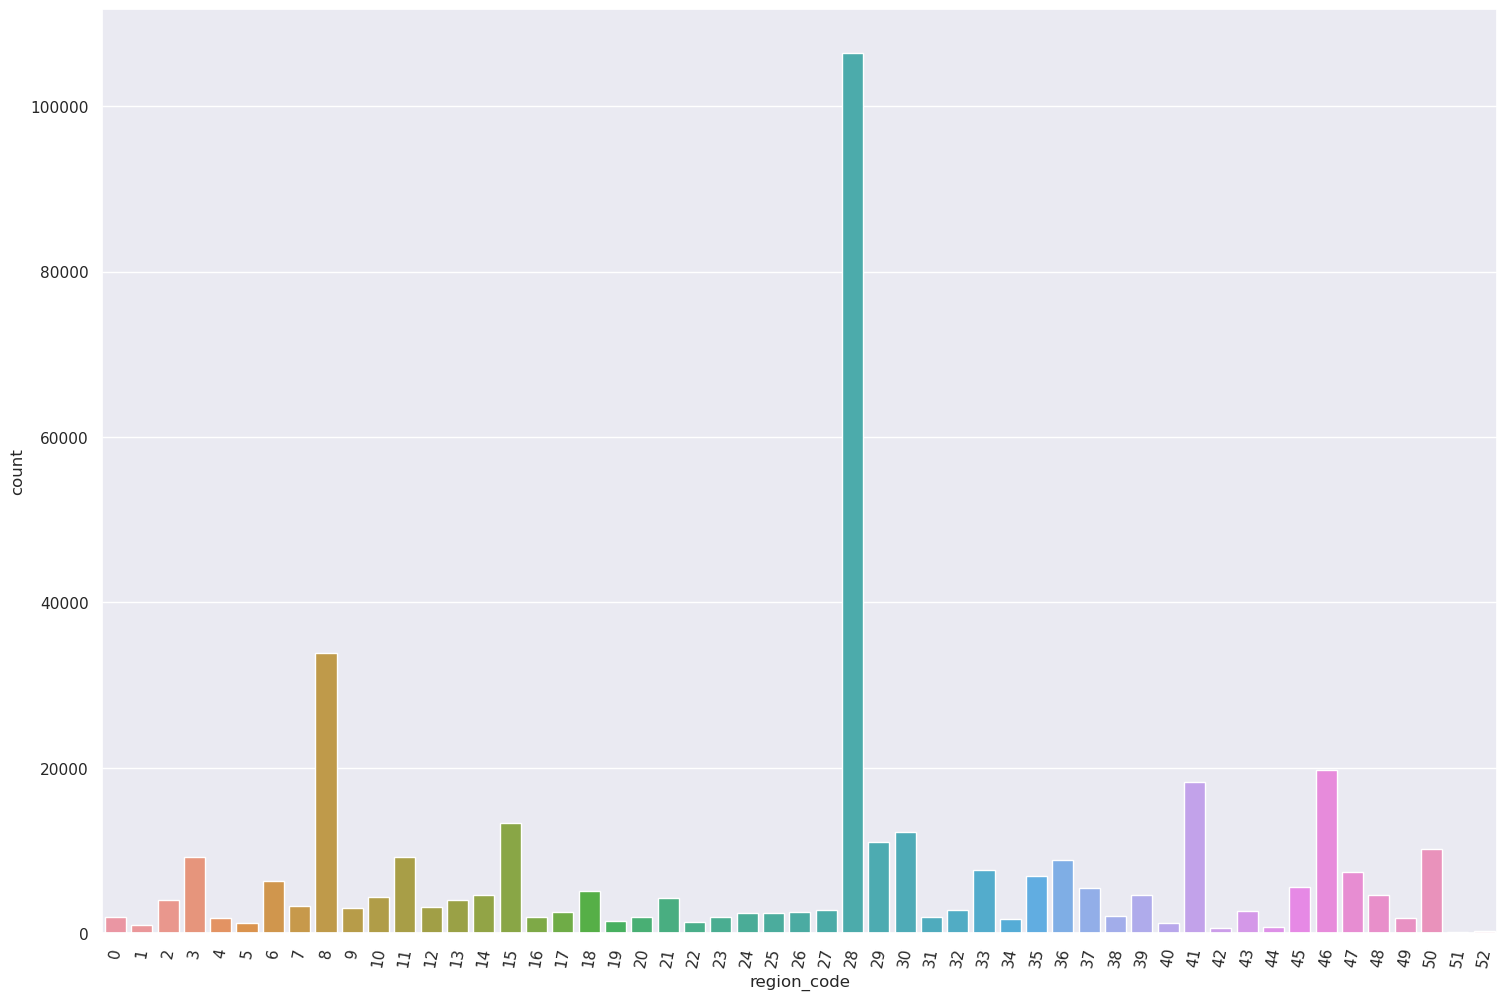

In [19]:
#region_code
region_code = cat_attributes[['region_code','id']].groupby('region_code').count().reset_index()
region_code.columns = ['region_code','count']
region_code = region_code.sort_values('count', ascending =True)
sns.barplot(data=region_code, x = 'region_code', y='count')
plt.xticks(rotation = 80);

In [20]:
region_code['frequency'] = region_code['count']/sum(region_code['count'])
region_code = region_code.sort_values('frequency', ascending = False)
region_code.head(5)

,region_code,count,frequency
28,28,106415,0.279225
8,8,33877,0.088891
46,46,19749,0.051820
41,41,18263,0.047921
15,15,13308,0.034919


The 5 most frequent region code concentrates almost 50% of data

#### vehicle age, gender, driving license,  vehicle damage, previosly insured, age group, premium above medium age group 

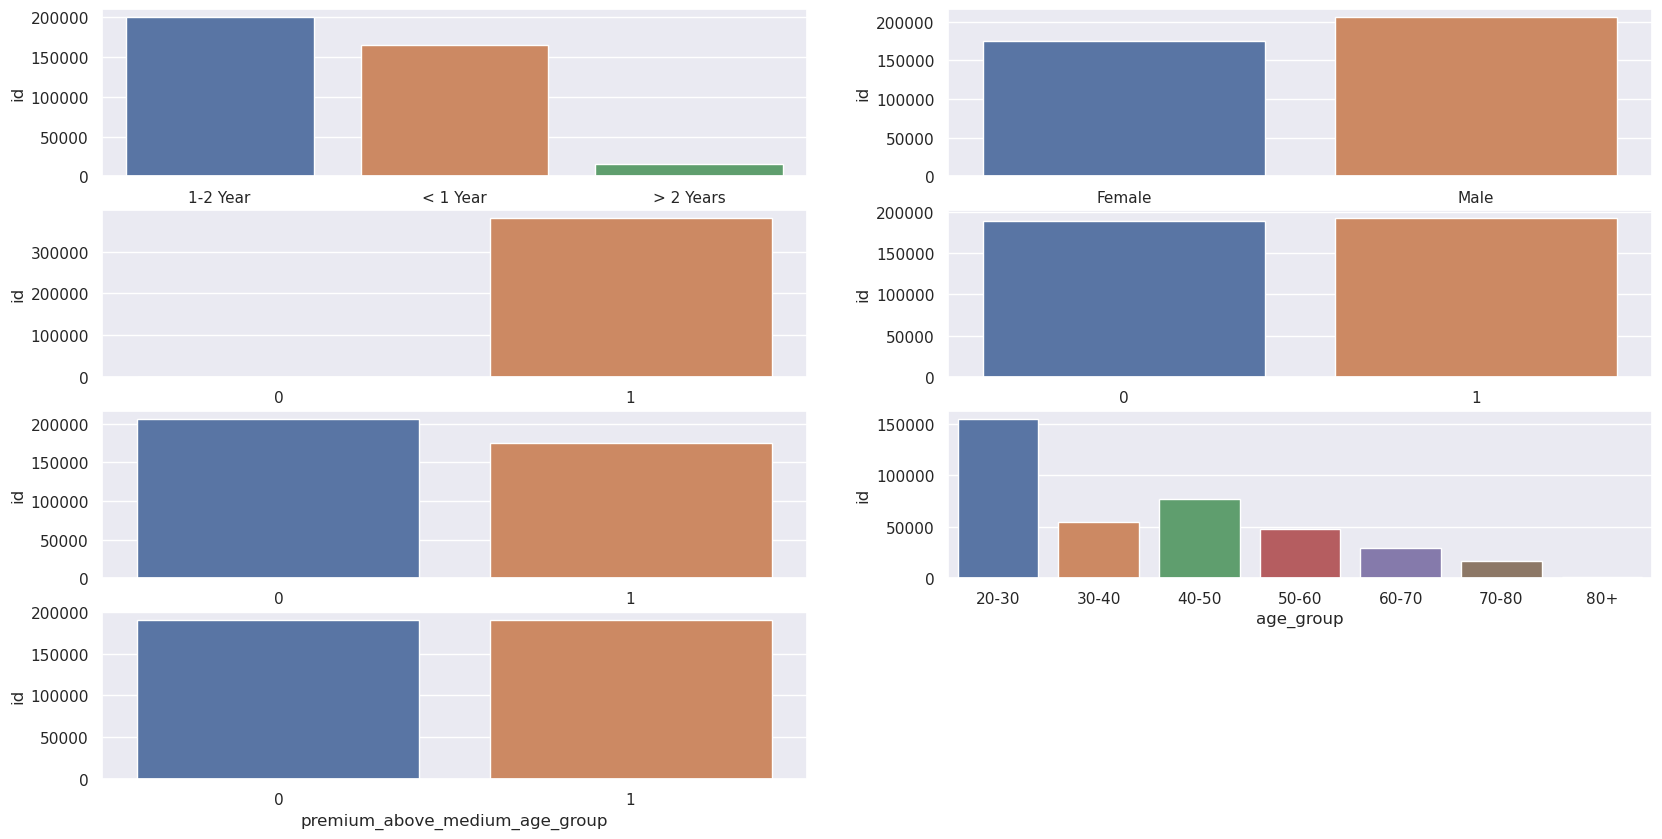

In [91]:
#vehicle_age
plt.subplot (4,2,1)
vehicle_age = df4[['vehicle_age','id']].groupby('vehicle_age').count().reset_index()
sns.barplot(data=vehicle_age, x='vehicle_age',y='id');

#gender
plt.subplot (4,2,2)
gender = df4[['gender','id']].groupby('gender').count().reset_index()
sns.barplot(data=gender, x= 'gender', y='id');

#driving_license
plt.subplot (4,2,3)
license = df4[['driving_license','id']].groupby('driving_license').count().reset_index()
sns.barplot(data=license, x= 'driving_license', y='id');

#vehicle_damage
plt.subplot(4,2,4)
vehicle_damage = df4[['vehicle_damage','id']].groupby('vehicle_damage').count().reset_index()
sns.barplot(data=vehicle_damage, x= 'vehicle_damage', y='id');

#previosly_insured
plt.subplot(4,2,5)
previously_insured = df4[['previously_insured','id']].groupby('previously_insured').count().reset_index()
sns.barplot(data=previously_insured, x= 'previously_insured', y='id');

# age group
plt.subplot (4,2,6)
age_group = df4[['age_group','id']].groupby('age_group').count().reset_index()
sns.barplot(data=age_group, x= 'age_group', y='id');

# premium_above_medium_age_group
plt.subplot (4,2,7)
premium_above_medium_age_group = df4[['premium_above_medium_age_group','id']].groupby('premium_above_medium_age_group').count().reset_index()
sns.barplot(data=premium_above_medium_age_group, x= 'premium_above_medium_age_group', y='id');

## Bivariate Analysis

### H1. The sales channels with the most interest have the best rates conversion
**FALSE** There is not a correlation between this features 

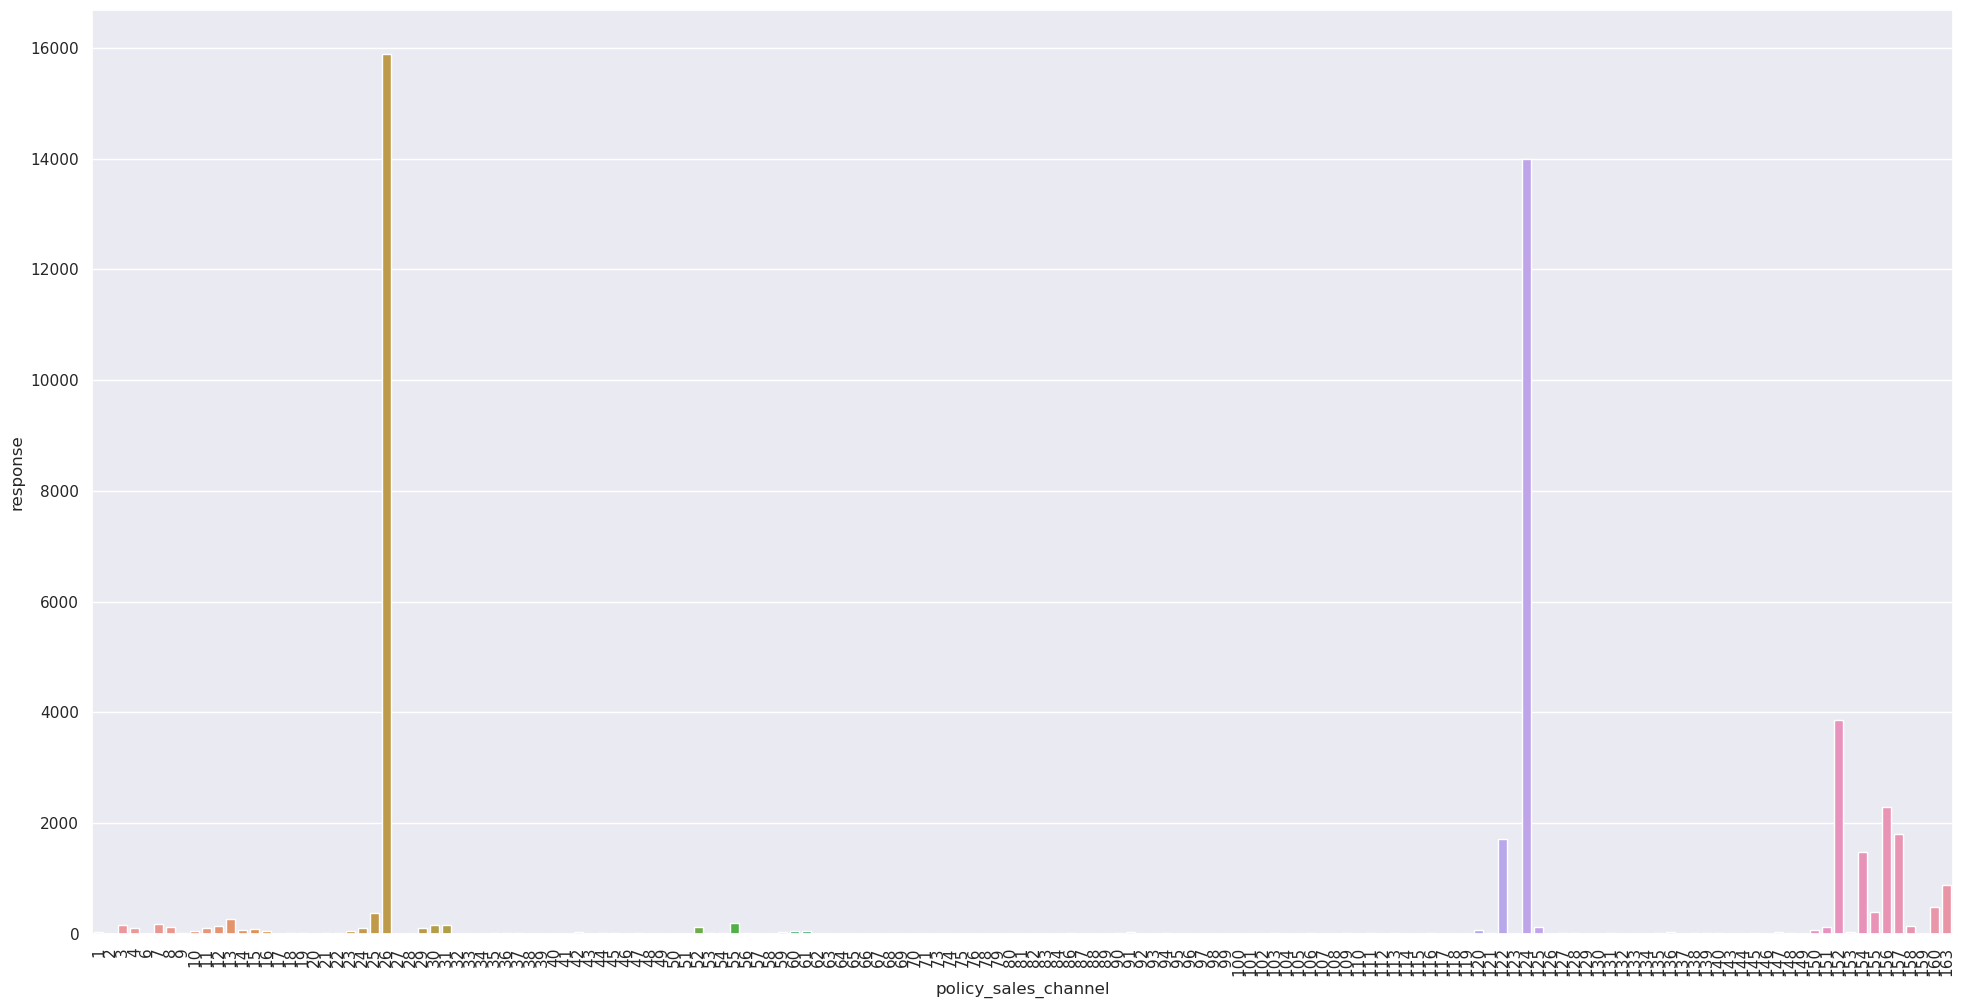

In [128]:
# policy_sales_channel
plt.figure (figsize =(24,12))
sales_channel = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(data=sales_channel, x = 'policy_sales_channel',y='response')
plt.xticks(rotation = 90);

(-1.0, 100.0)

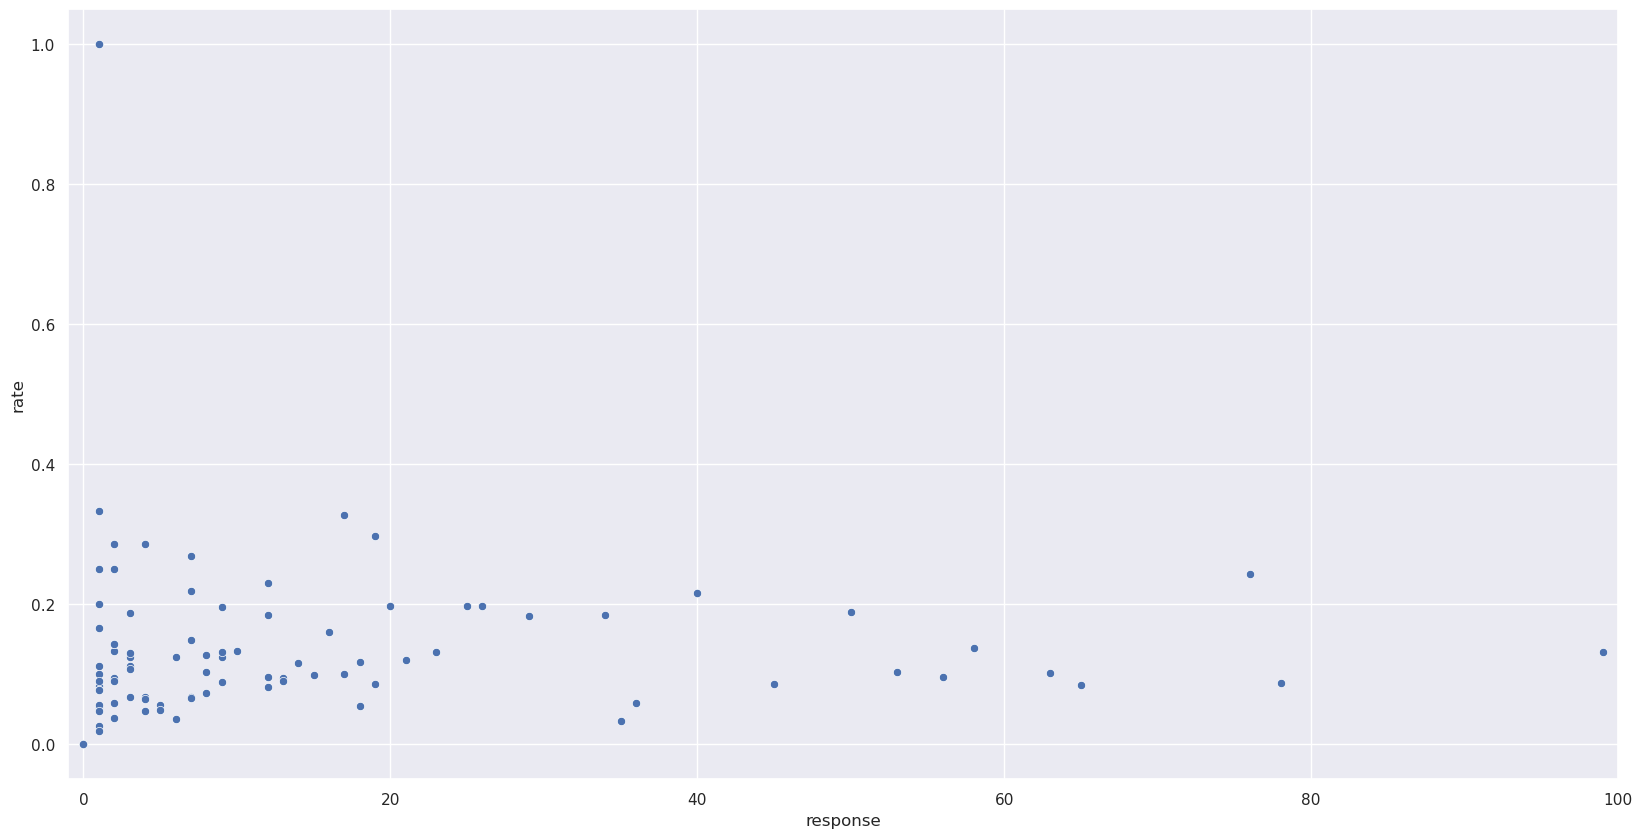

In [140]:
# policy_channel_rates
aux = pd.DataFrame(df4.groupby('policy_sales_channel')['response'].count().reset_index())
aux = aux.rename(columns={'response':'total'})
# sales_channel = pd.merge(sales_channel,aux,on=['policy_sales_channel','policy_sales_channel'])
sales_channel['rate'] = sales_channel['response']/sales_channel['total']

fig, ax = plt.subplots()
sns.scatterplot(data = sales_channel[['response','rate']], x='response', y='rate', ax=ax)
ax.set_xlim(-1, 100)


### H2. Interest is greater at customers older than 30 years old
**TRUE** The interested concetrate in ages above 30 years old 

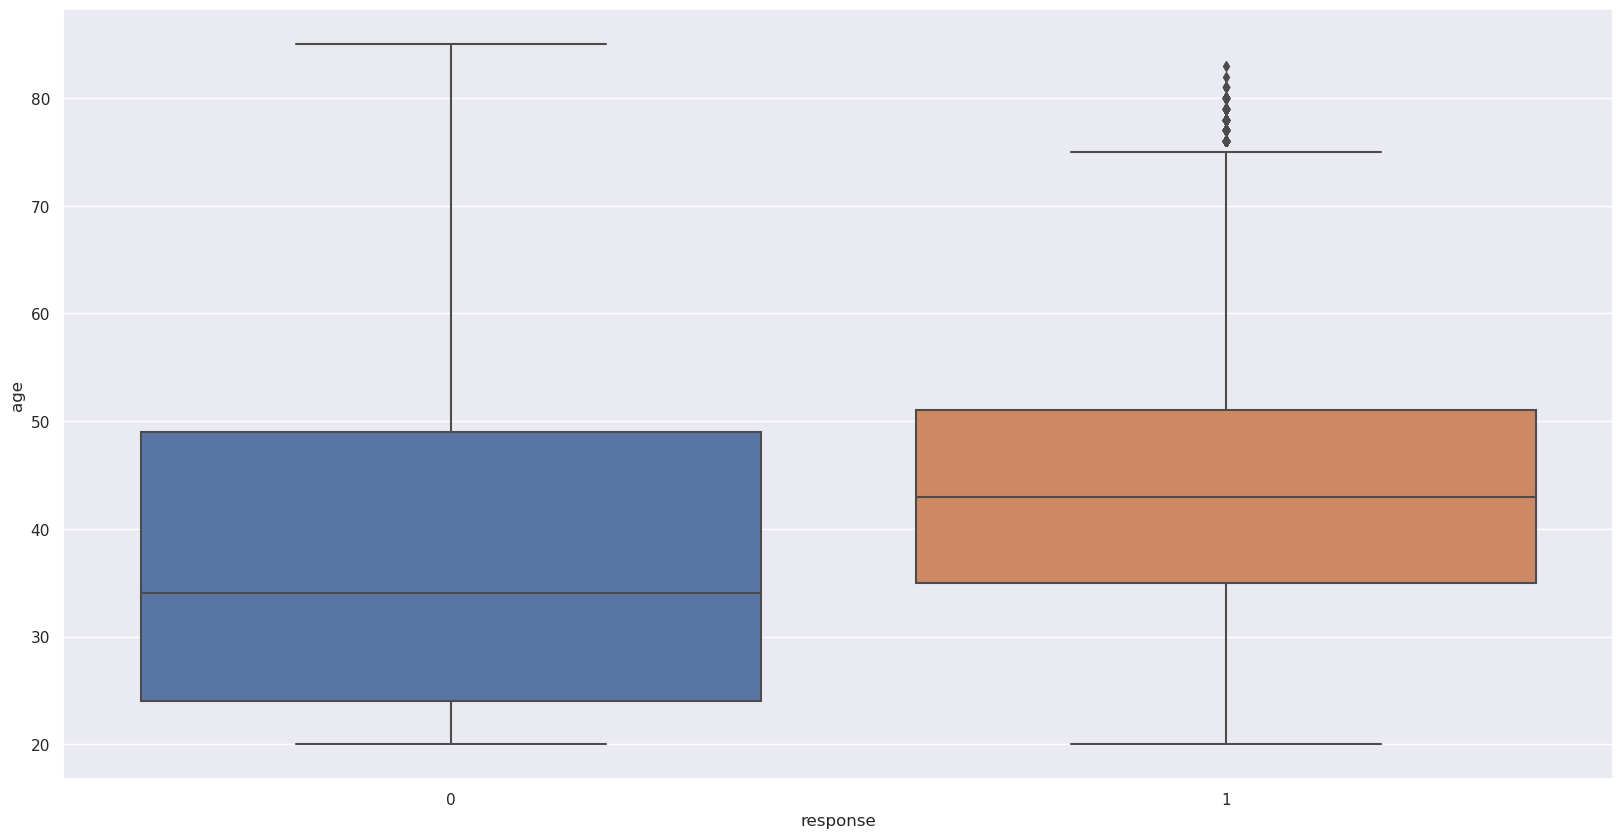

In [143]:
# age
aux1 = df4[['response', 'age']]
sns.boxplot(data=aux1, x='response', y='age');

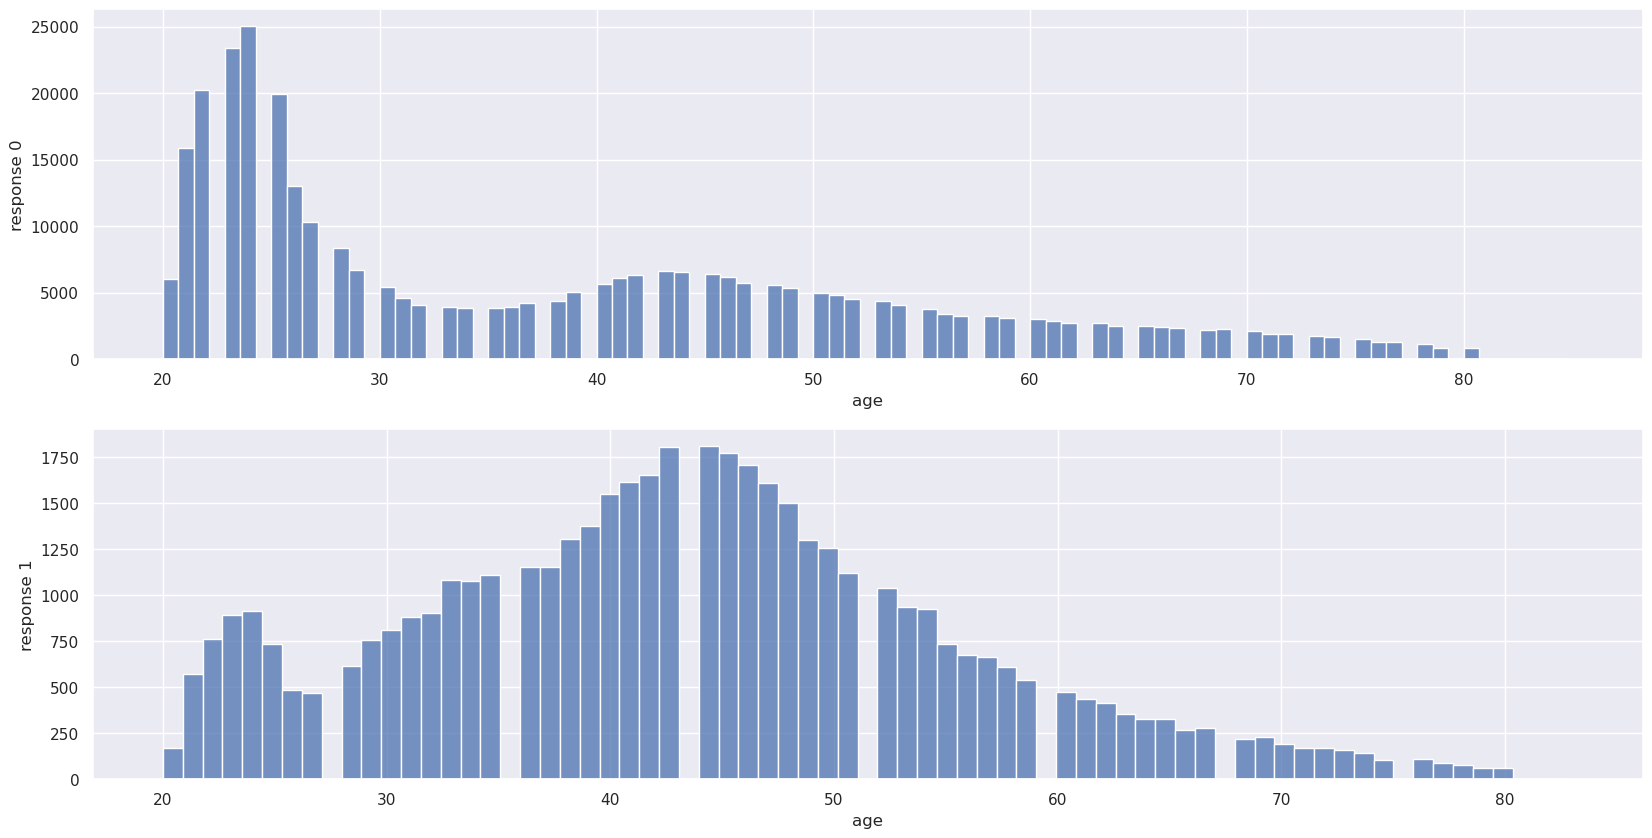

In [147]:
plt.subplot (2,1,1)
aux2 = aux1.loc[aux1['response']==0]
sns.histplot(data=aux2, x='age').set( ylabel = 'response 0');

plt.subplot (2,1,2)
aux2 = aux1.loc[aux1['response']==1]
sns.histplot(data=aux2, x='age').set( ylabel='response 1') ;

The median age is higher among people who showed interest, compared to people who did not. The age attribute has differents distribuition related to the response variable and can be an important variable for the model.

### H3. Interest is greater within woman
**FALSE** It cannot be said that there is a relevant differenc in interest between woman and man 

In [150]:
#gender
gender = df4[['gender', 'response']].value_counts(normalize = True).reset_index()
gender

,gender,response,0
0,Male,0,0.465914
1,Female,0,0.411523
2,Male,1,0.074847
3,Female,1,0.047716


<AxesSubplot: xlabel='gender', ylabel='0'>

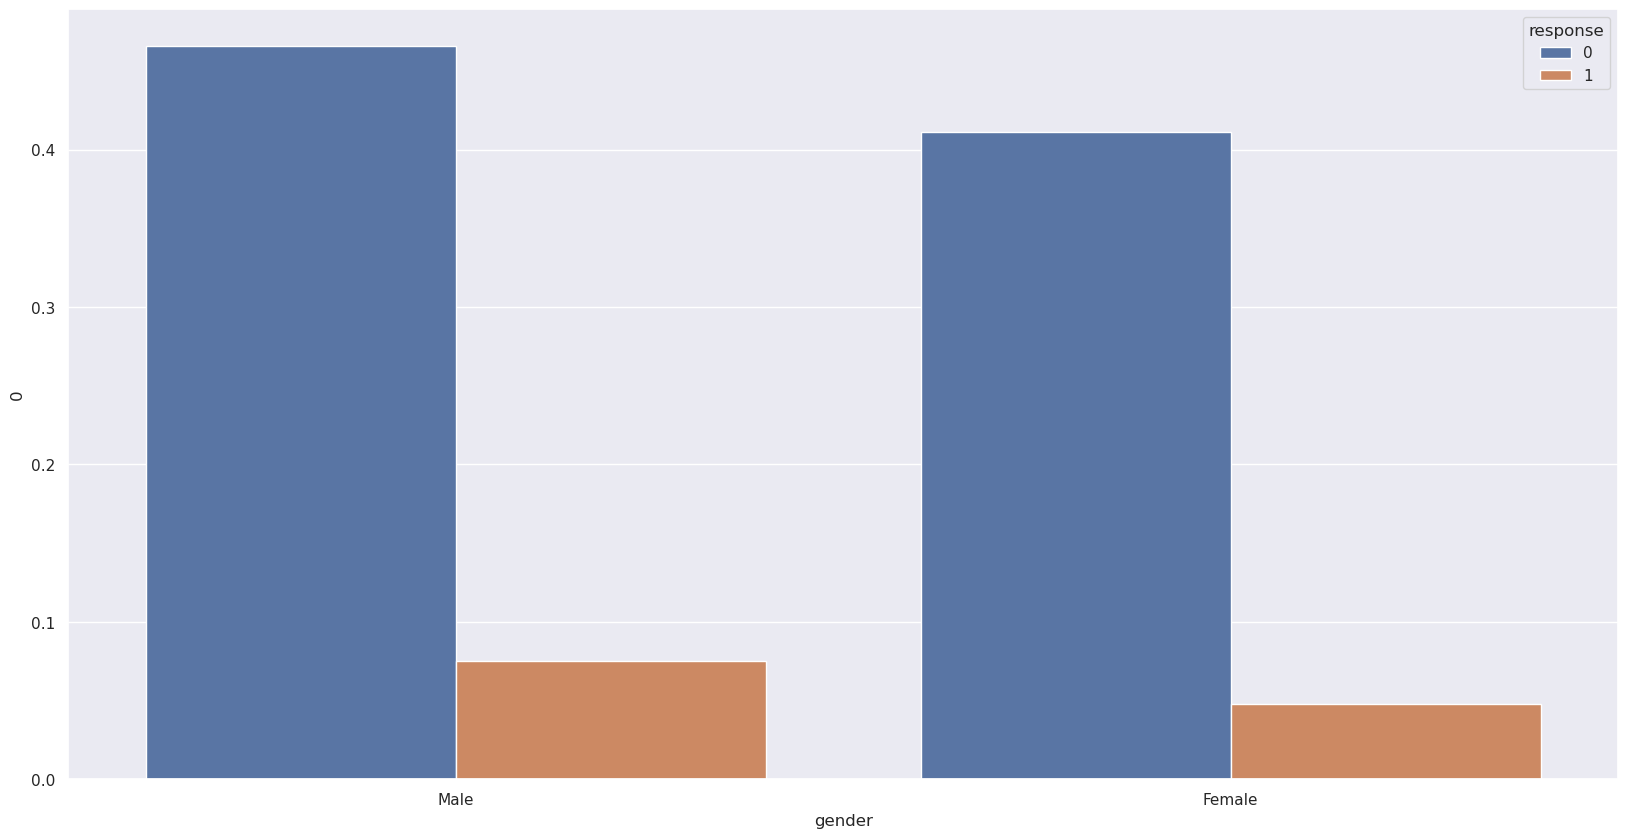

In [162]:
# gender1 = df4[['gender','response']].groupby('gender').count().reset_index()
sns.barplot(data=gender, x='gender',y=0, hue='response')

### H4. Interest rate is greater on newer vehicles
**FALSE** The newer vehicles have the lower interest among the vehicle age classes

In [164]:
#vehicle age
vehicle_age = df4[['vehicle_age','response']].value_counts(normalize=True).reset_index().sort_values('vehicle_age')
vehicle_age

,vehicle_age,response,0
0,1-2 Year,0,0.434285
2,1-2 Year,1,0.091328
1,< 1 Year,0,0.413488
4,< 1 Year,1,0.018897
3,> 2 Years,0,0.029663
5,> 2 Years,1,0.012338


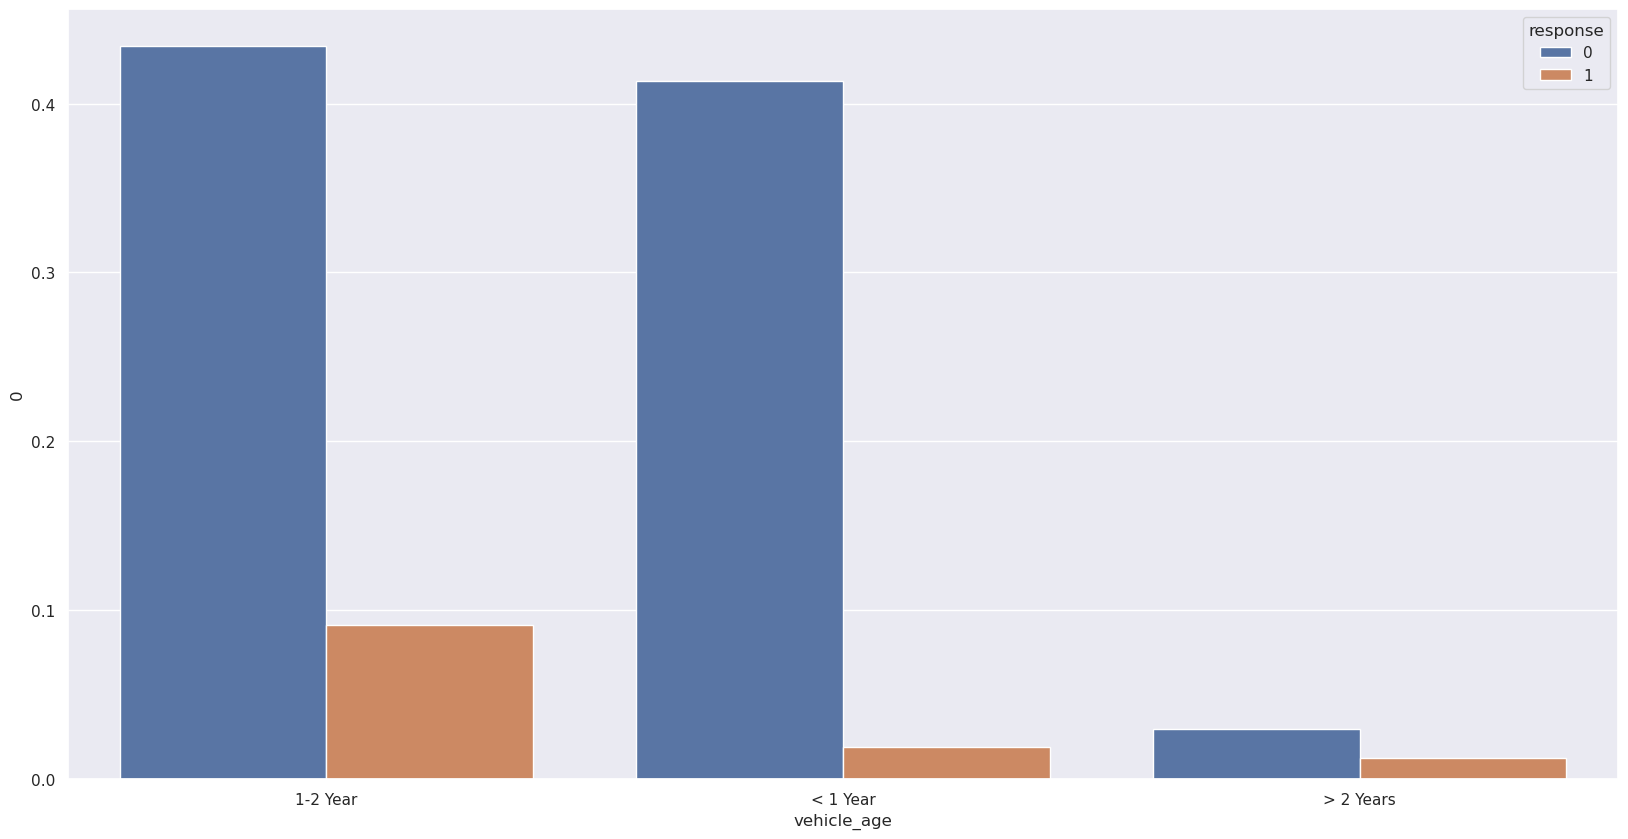

In [166]:
sns.barplot (data = vehicle_age, x='vehicle_age', y=0, hue='response');

### H5. Interest rate is greater when vehicle has already damaged
**TRUE** Interest rate is 20 bips greater when the vehicle has already damaged 

From the frequency table above, it can be seen that people who have had their vehicles damaged have greater adherence to the insurance proposal than those who have not had any incidents.

<AxesSubplot: xlabel='response', ylabel='vehicle_damage'>

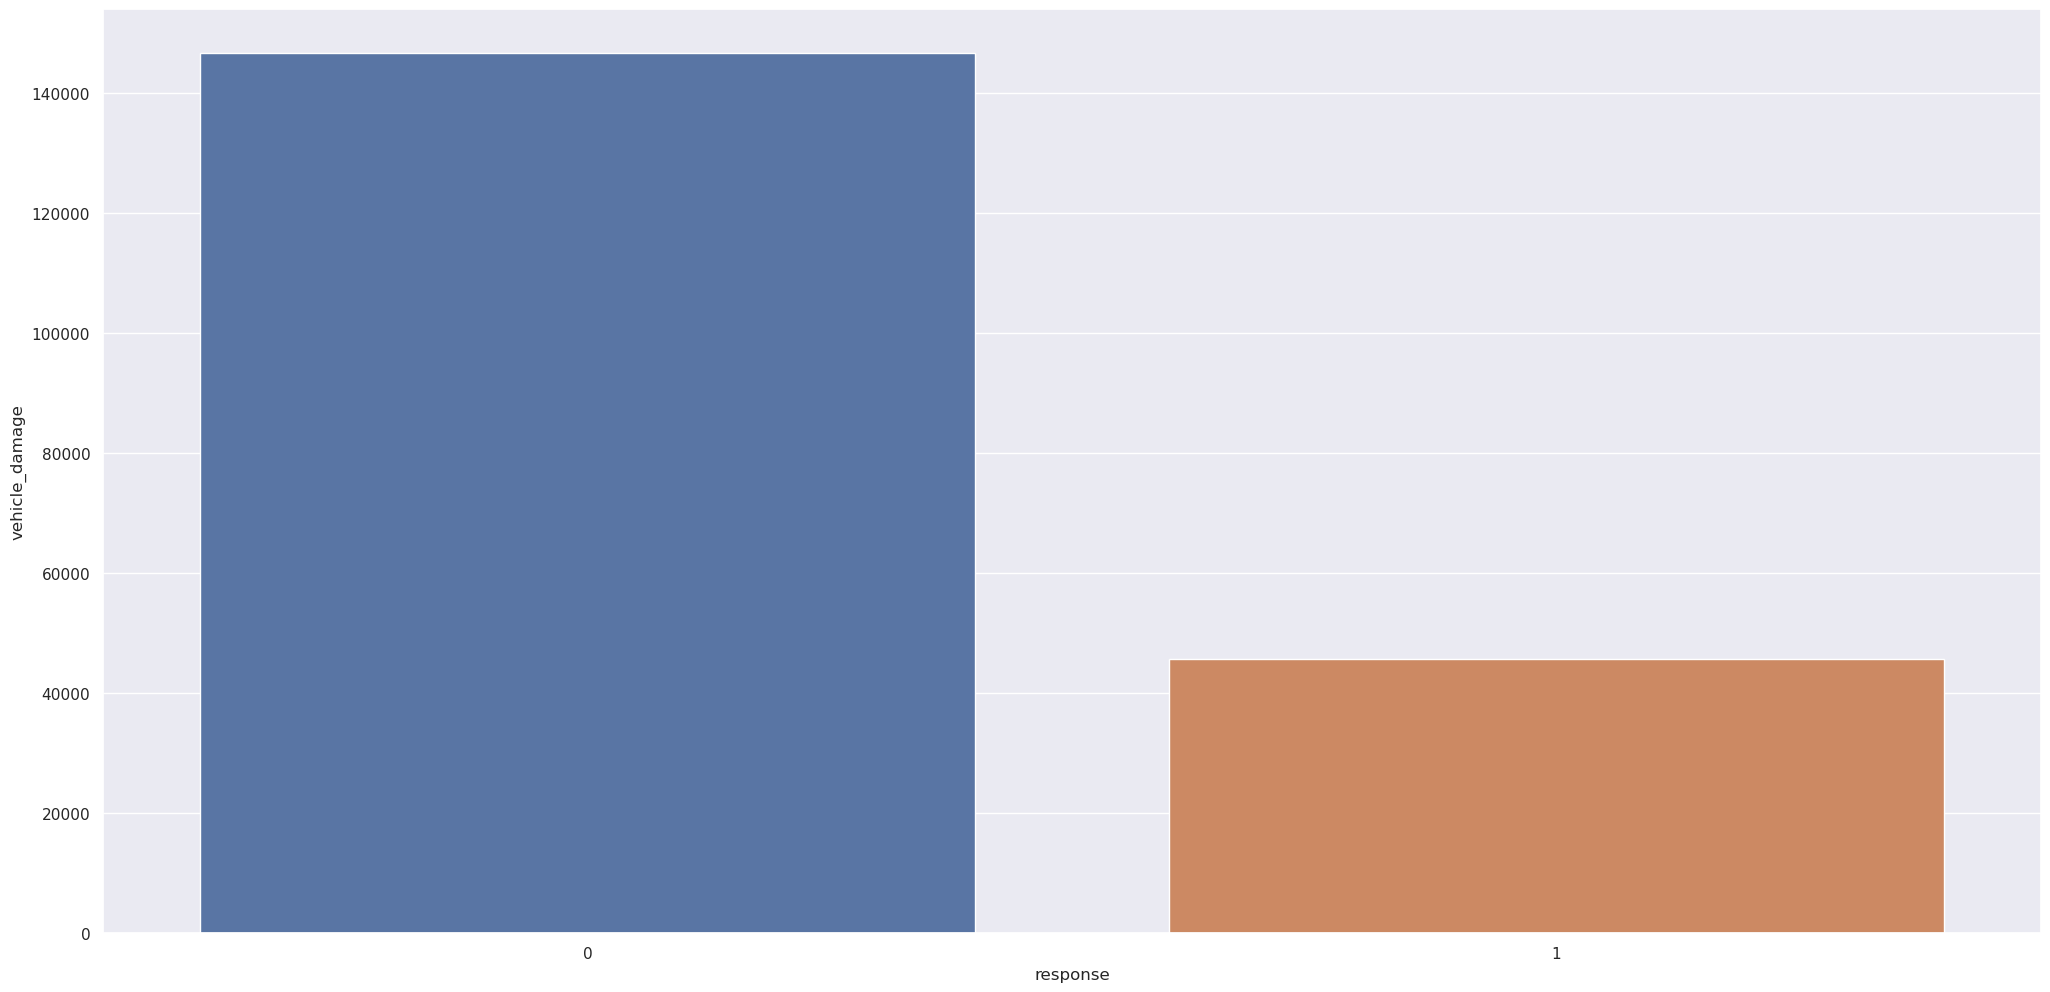

In [138]:
#vehicle_damage
vehicle_damage = df4[['vehicle_damage','response']].groupby('response').sum().reset_index()
sns.barplot(data=vehicle_damage, x= 'response', y='vehicle_damage')

In [159]:
pd.crosstab(df4['vehicle_damage'],df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
vehicle_damage,,
0,0.994796,0.005204
1,0.762345,0.237655


### H6. Interest is greater within insurance vintage with more than 6 months
**FALSE** It cannot be said that customers insured for more than 6 months have more interested in car insurance

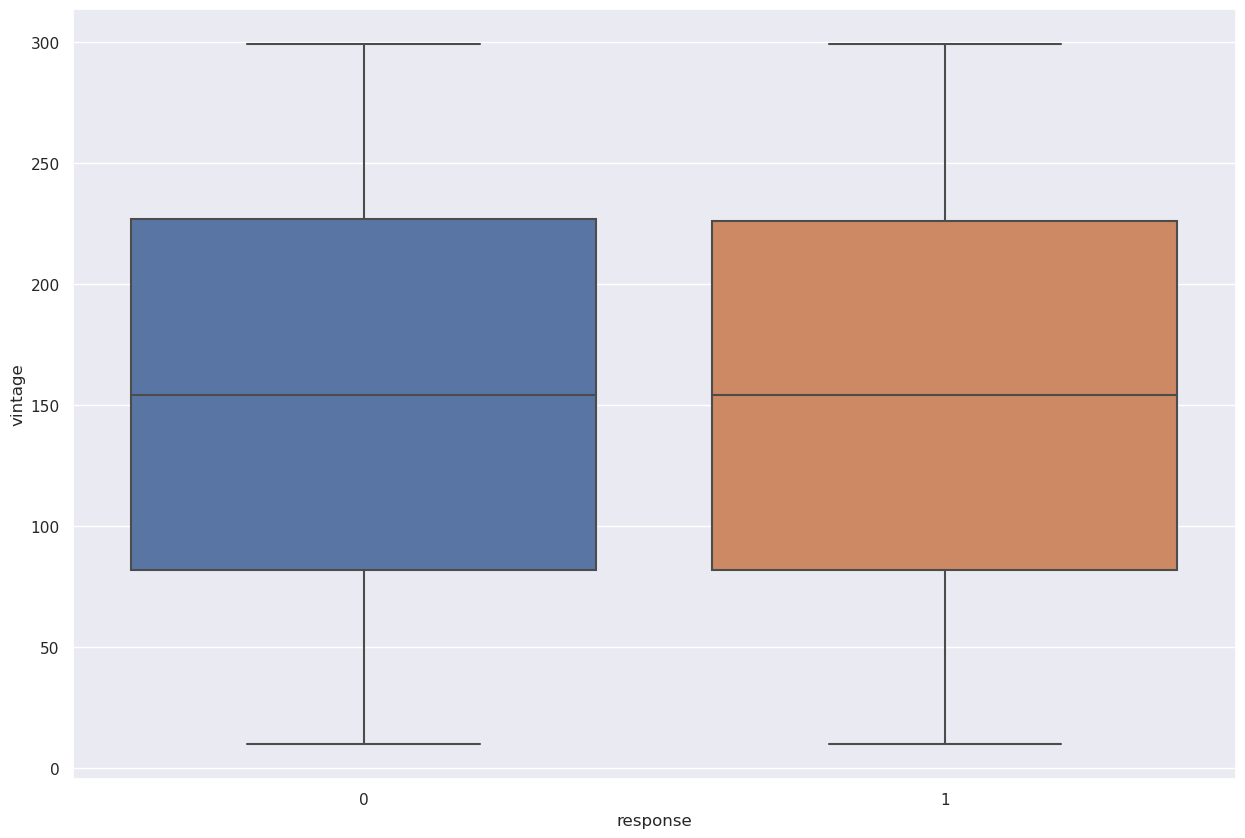

In [65]:
# vintage
aux1 = df4[['response', 'vintage']]
sns.boxplot(data=aux1, x='response', y='vintage');


There were no relevant differences in the distribution of vintage values ​​between the two classes of the response variable. Thus, few conclusions can be derived from this feature.

### H7. Interest is higher among customers with annual premium above 30K 
**TRUE** It is possible to say that interest is higher above 30k of annual premium 

Since there is no way to classify how strong the interest is, I focused on what point of distribuition of annual premium, the value of 30k is 

In [193]:
from scipy import stats
aux = df4.loc[(df4['response']==1)]
percentile = int(stats.percentileofscore(aux['annual_premium'], 30000, kind='weak'))
print('Annual premium 30k represents {} percentile'.format(percentile))

Annual premium 30k represents 39 percentile


#### Diving into annual_premium x response 

In depth analisys, I studied how annual premium behave towards response. So, annual premium was filtered at 100000 since above that only 0.17% of data remain. 

It was not observed relevant diferences in the distribuition of annual premium between this two boolean classes. Both have almost a normal distribuition and a median annual premium near 40000. 

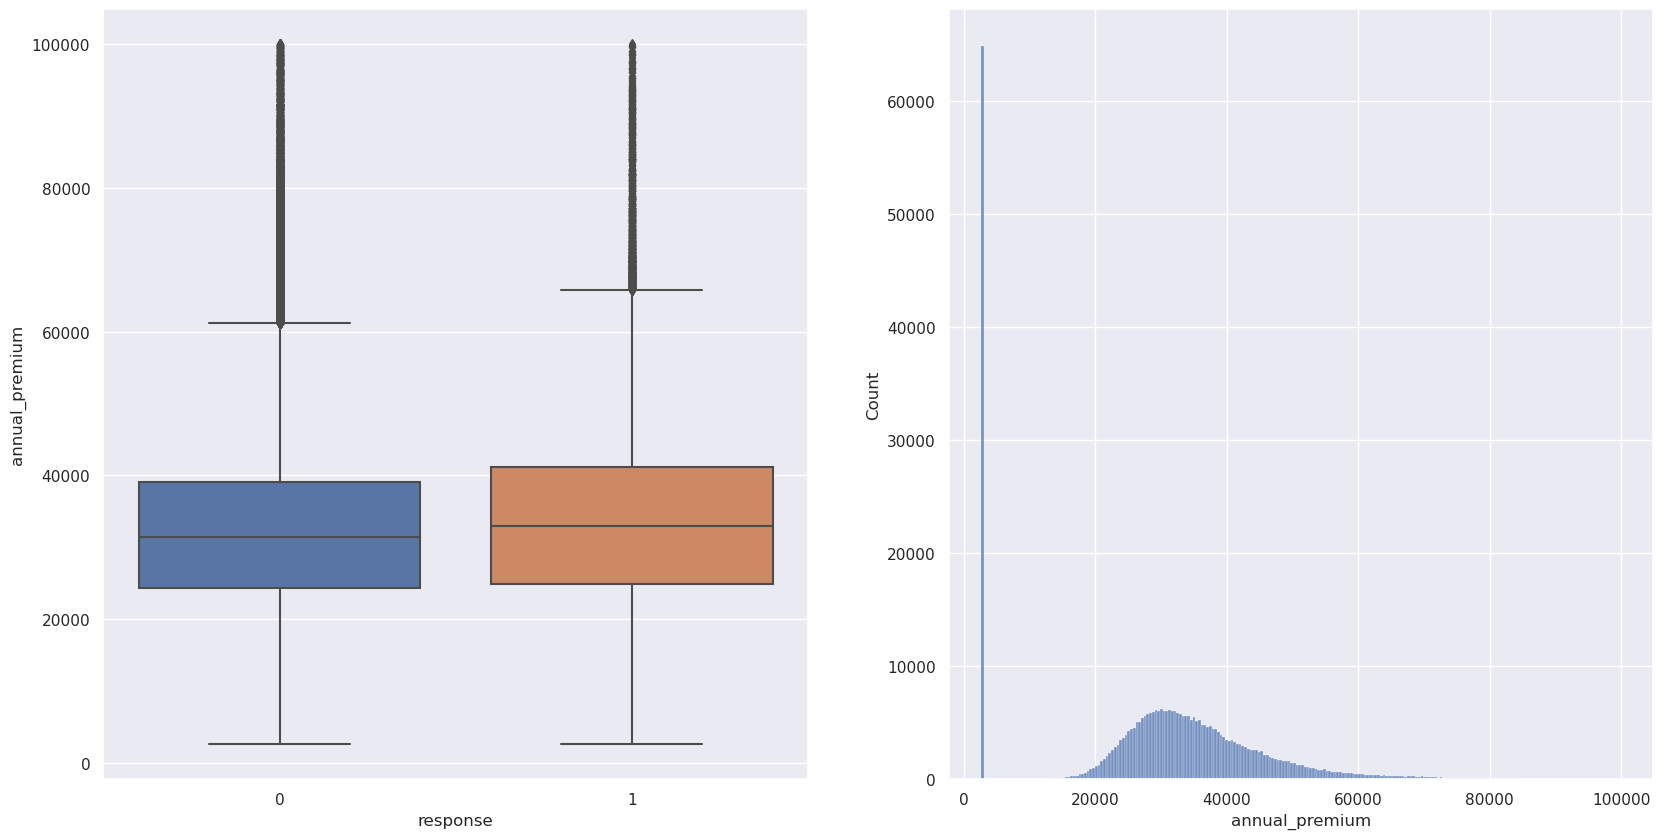

In [174]:
# annual_premium
aux1 = df4.loc[(df4['annual_premium']<100000),['annual_premium','response']]

plt.subplot(1,2,1)
sns.boxplot(data = aux1, x='response',y='annual_premium')

plt.subplot(1,2,2)
sns.histplot(data=aux1,x='annual_premium');

Diving into the high concentration of annual premium at the left side of distribuition, especificaly where *'annual_premium' = 2630*, the most of responses remains equal to 0, that is, they would not be interested in the proposal. 

In this sample, no difference was noted in the frequency of positive responses in relation to the entire dataset.

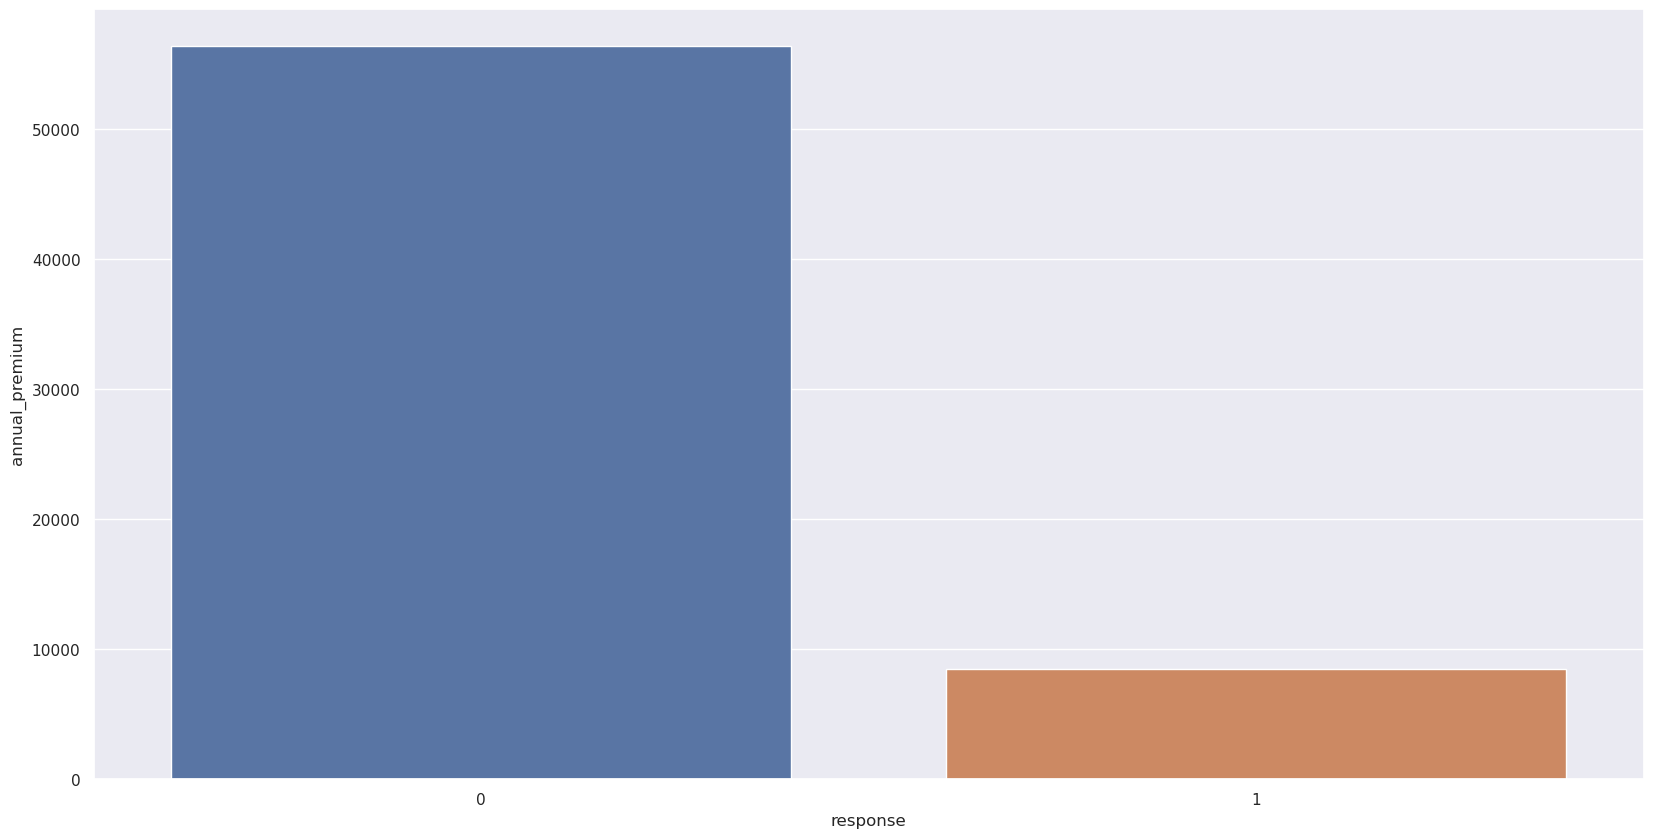

In [175]:
aux2 = aux1.loc[aux1['annual_premium']<3000].groupby('response').count().reset_index()
sns.barplot(data=aux2, x='response', y='annual_premium');

In [60]:
aux2['frequency'] = aux2['annual_premium']/sum(aux2['annual_premium']);
aux2

,response,annual_premium,frequency
0,0,56372,0.868906
1,1,8505,0.131094


### H8. Region with high ratio of interested have higher ratio of older people 
**FALSE** Average age of each region does not seem to influence the ratio of interesteds

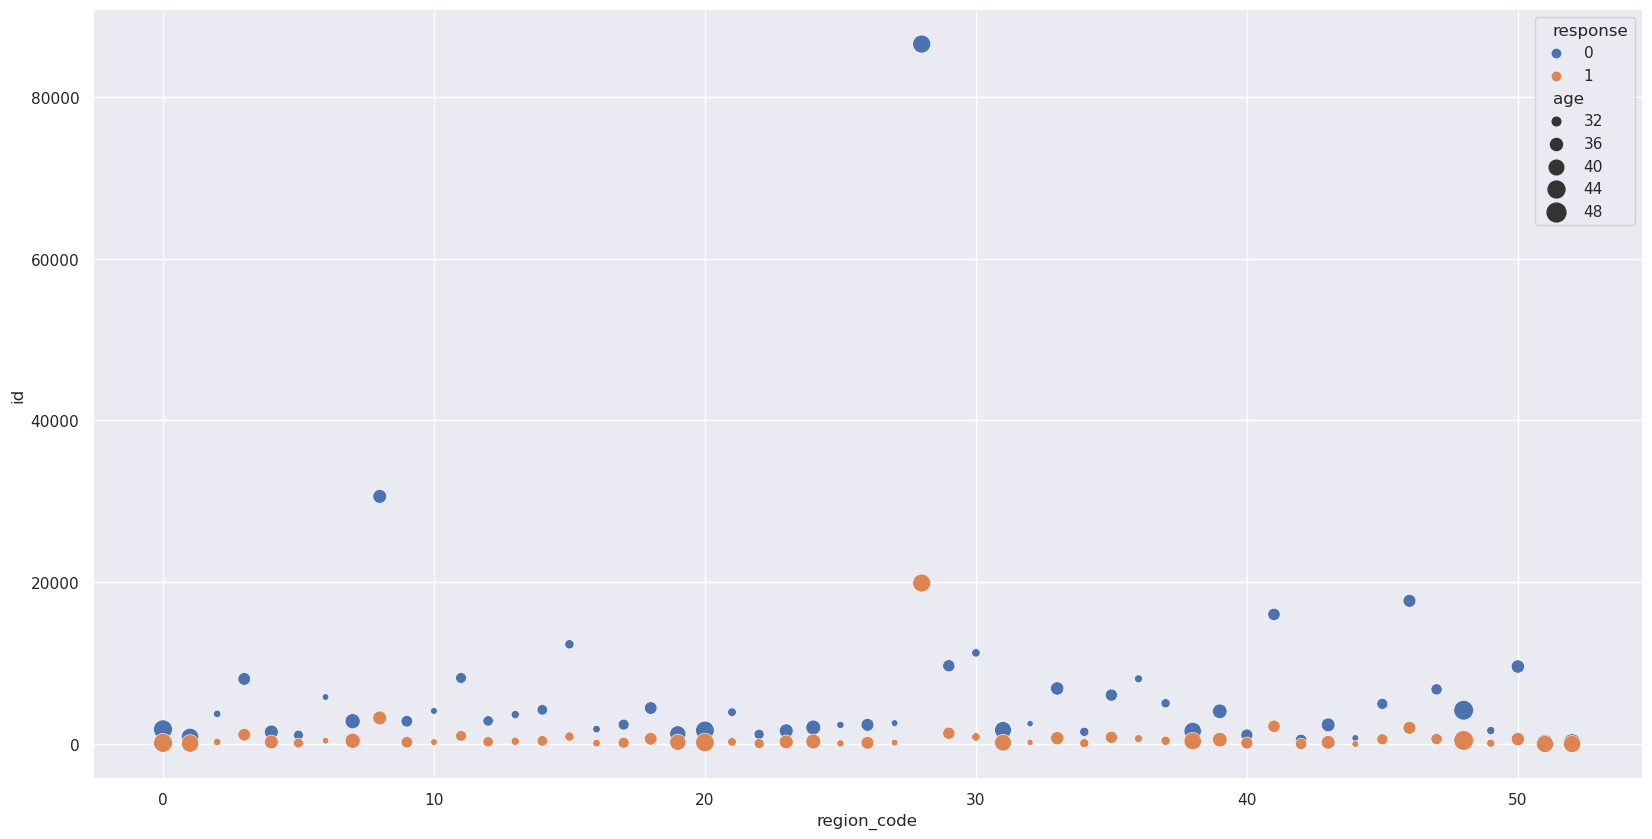

In [202]:
#region_code
region_code = df4[['region_code','response','id']].groupby(['region_code','response']).count().reset_index()
age_map = df4.groupby('region_code')['age'].mean()
region_code['age'] = region_code['region_code'].map(age_map)
sns.scatterplot(data=region_code, x = 'region_code', y='id', hue='response', size='age', sizes = (20,200));


From the graph above, except for some region_codes, the proportion of customers who would accept the proposal is similar to those who would not accept the proposal.


### H9. Less than 10% of interested does not have driving license
**TRUE** 5% of interested does not have driving license

In [207]:
pd.crosstab(df4['driving_license'],df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
driving_license,,
0,0.949507,0.050493
1,0.877283,0.122717


### H10. Interest is greater among those who do not have previously insurance
**TRUE** There is no relevant interest among those who have previously insured

In [154]:
#previosly_insured
pd.crosstab(df4['previously_insured'],df4['response']).apply(lambda x: x/x.sum(),axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


From the table above, it is almost certain that if the person has car insurance, he will not want to purchase a new service.

## Multivariate Analysis

### Numerical Attributes

<AxesSubplot: >

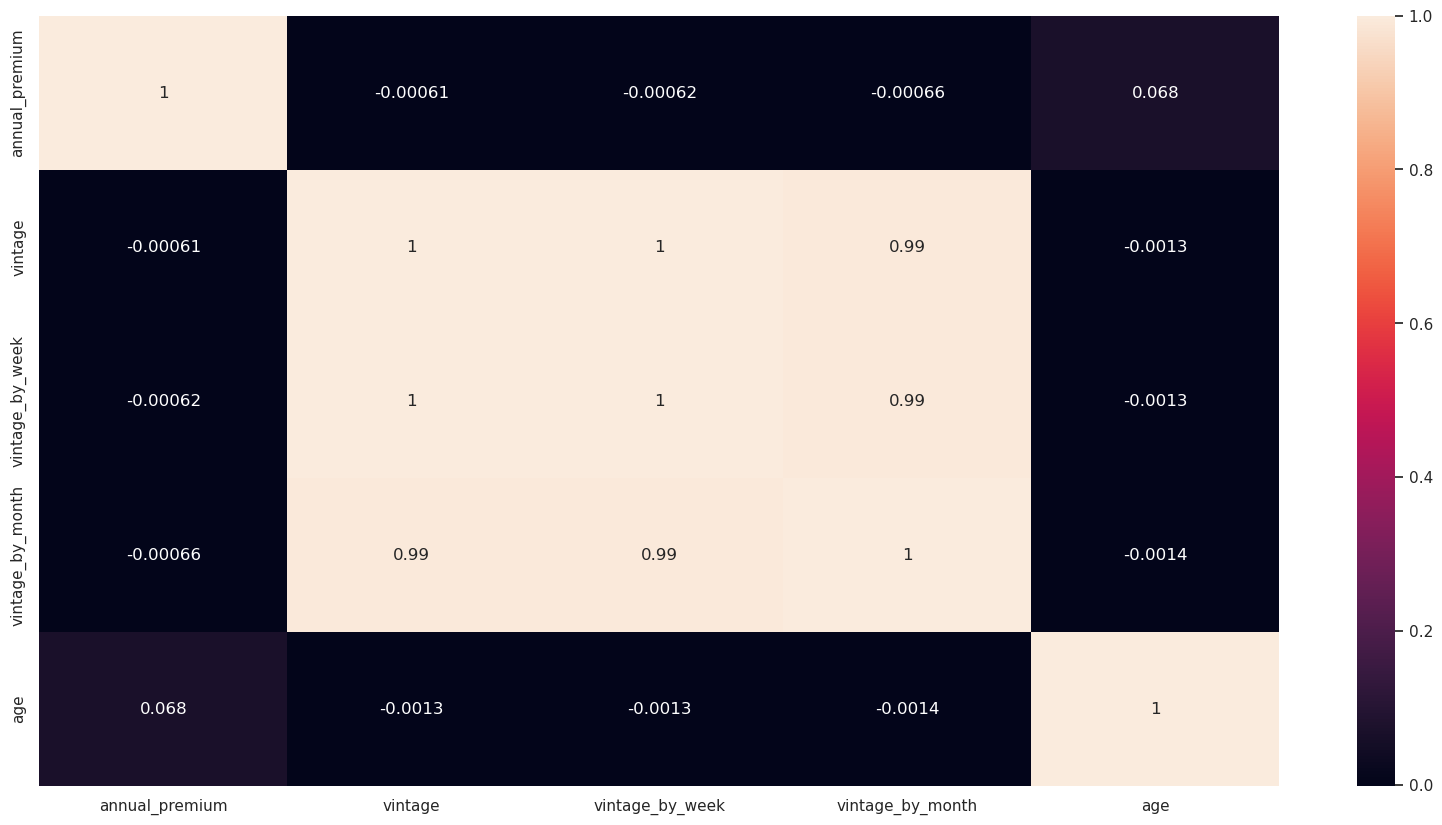

In [8]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot=True )

### Categorical Attributes

In [11]:
cat = cat_attributes.copy()

<AxesSubplot: >

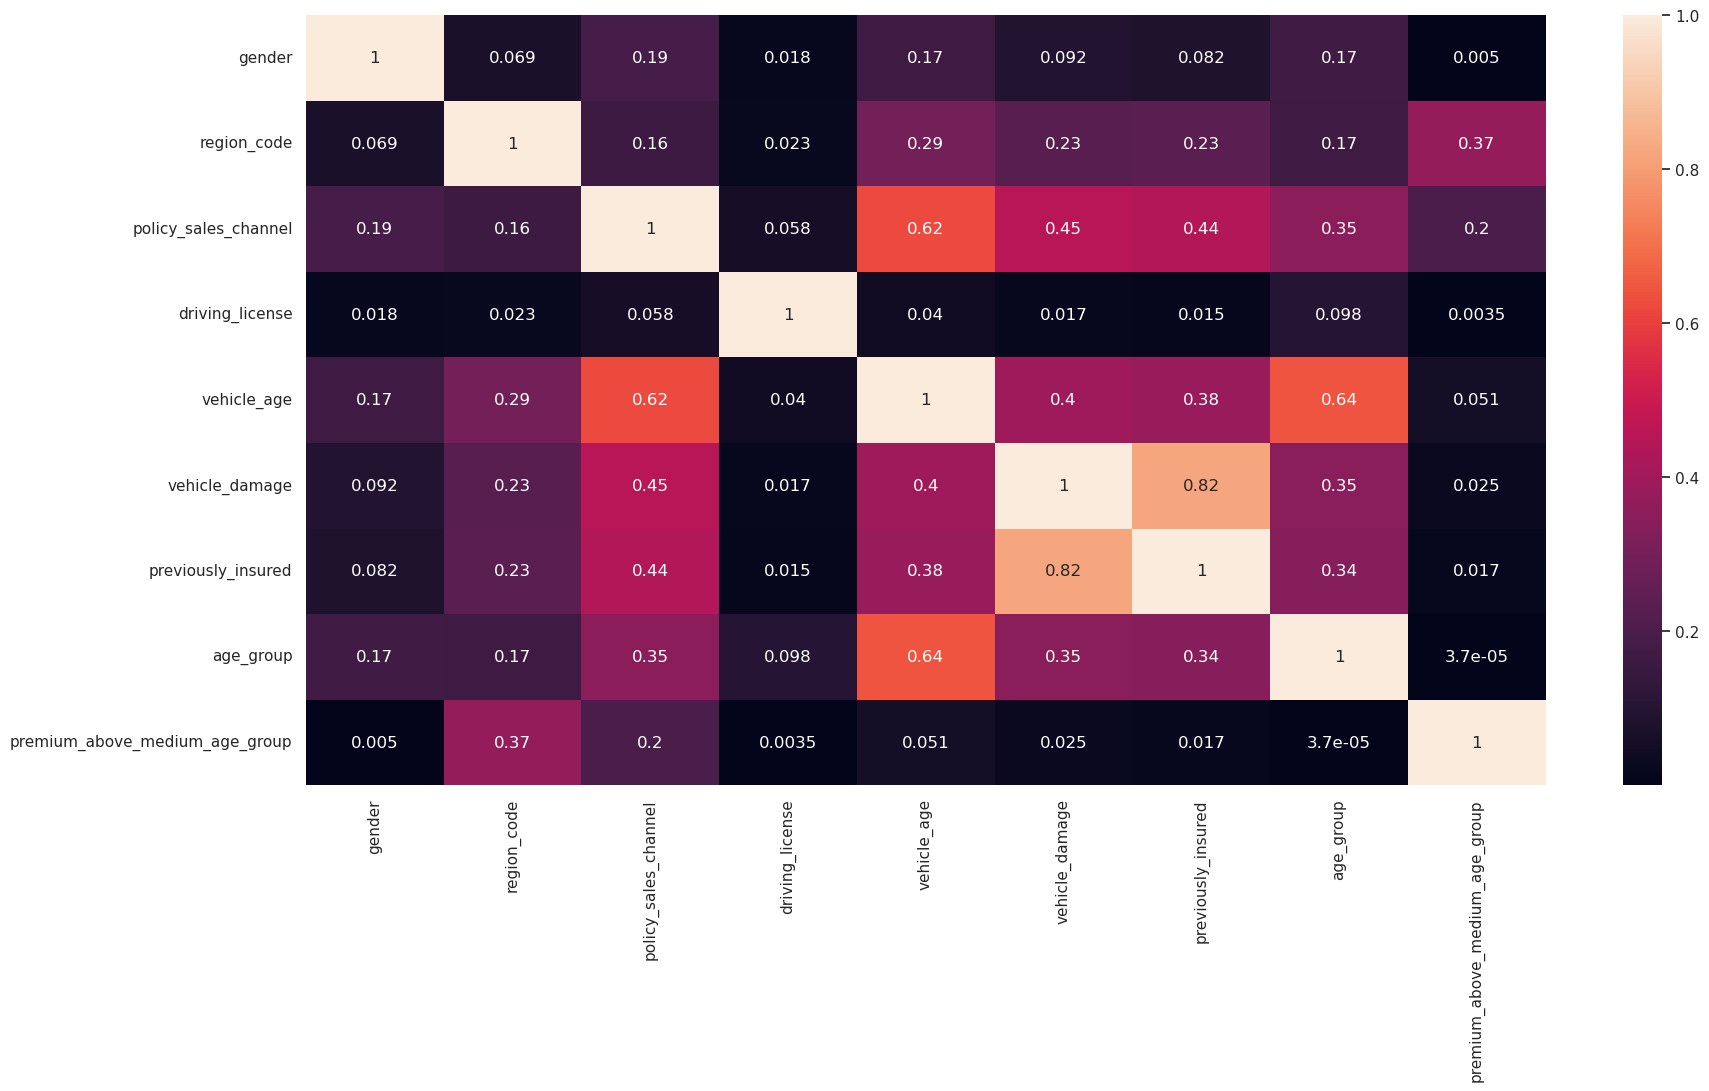

In [102]:
# calculate cramer_v 

cat_list = cat.columns.tolist()

dict_attribute = {}

for attribute in cat_list: 
    
    attribute_list = []
    
    for index, value in enumerate (cat_list): 
        
        attribute_list.append(cramer_v(cat[attribute], cat[value]))
        
        dict_attribute[attribute] = attribute_list
        

final_dataset = pd.DataFrame(dict_attribute)
    
final_dataset = final_dataset.set_index(final_dataset.columns)

sns.heatmap(final_dataset, annot = True)       

In [33]:
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/data/interim/eda.csv'

df4.to_csv(path, index=False)

# DATA PREPARATION 
**Step 5 - CRISP**

In [34]:
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/data/interim/eda.csv'

df5 = pd.read_csv (path)

## Split dataset into train and validation

In [40]:
X = df5.drop('response',axis=1)
y = df5['response']
X_train, X_validation, y_train, y_validation = train_test_split(X,y,
                                                    random_state=42,
                                                    test_size=0.2,
                                                    shuffle=True)
df5_train = pd.concat([X_train, y_train],axis=1)
df5_validation = pd.concat([X_validation,y_validation], axis=1)

In [41]:
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/data/interim/'

df5_train.to_csv(path + 'train_splited.csv', index=False)
df5_validation.to_csv(path + 'validation_splited.csv', index=False)


## Standardization

In [42]:
# Instancing StandardScaler
ss = StandardScaler()

df5_train['annual_premium'] = ss.fit_transform(df5_train[['annual_premium']].values)
pickle.dump(ss, open('/home/daniel/repos/pa04_health_insurance_cross_sell/health_insurance_app/features/annual_premium_scaler.pkl', 'wb'))   

## Rescaling

In [43]:
# Instancing MinMaxScaler
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# Training and applying scaler
# 'age'
df5_train[['age']] = mms_age.fit_transform (df5_train[['age']].values)
pickle.dump (mms_age, open('/home/daniel/repos/pa04_health_insurance_cross_sell/health_insurance_app/features/age_scaler.pkl', 'wb'))


# 'vintage'
df5_train[['vintage']] = mms_vintage.fit_transform (df5_train[['vintage']].values)
pickle.dump (mms_vintage, open('/home/daniel/repos/pa04_health_insurance_cross_sell/health_insurance_app/features/vintage_scaler.pkl', 'wb'))


Apesar de instanciar dois objetos a partir da mesma classe MinMaxScaler, entendo que nao haveria problema algum instanciar apenas um objeto para acessar o metodo fit_transform da classe. Os parametros passados para esse metodo, por obvio, nao alterariam o metodo em si, e separar em dois objetos foi mais uma escolha para organizar o pensamento

## Encoding

In [44]:
# One Hot Encoder
# 'gender'
df5_train = pd.get_dummies(data=df5_train, columns = ['gender'], prefix='gender')


# Target Encoder 
# 'region_code'
target_encoder_region_code = df5_train.groupby('region_code')['response'].mean()
df5_train['region_code'] = df5_train['region_code'].map(target_encoder_region_code)
pickle.dump (target_encoder_region_code, open('/home/daniel/repos/pa04_health_insurance_cross_sell/health_insurance_app/features/region_code_scaler.pkl', 'wb'))

# 'policy_sales_channel'
target_encoder_sales_channel = df5_train.groupby('policy_sales_channel')['response'].mean()
df5_train['policy_sales_channel'] = df5_train['policy_sales_channel'].map(target_encoder_sales_channel)
pickle.dump (target_encoder_sales_channel, open('/home/daniel/repos/pa04_health_insurance_cross_sell/health_insurance_app/features/policy_sales_channel_scaler.pkl','wb'))


# 'vehicle_age'
target_encoder_vehicle_age = df5_train.groupby('vehicle_age')['response'].mean()
df5_train['vehicle_age'] = df5_train['vehicle_age'].map(target_encoder_vehicle_age)
pickle.dump (target_encoder_vehicle_age, open('/home/daniel/repos/pa04_health_insurance_cross_sell/health_insurance_app/features/vehicle_age_scaler.pkl', 'wb'))


## Preprocessing validation dataset 

In [45]:
# Standard Scaler
# annual_premium
X_validation['annual_premium'] = ss.transform(X_validation[['annual_premium']].values)

# MinMax Scaler
# age
X_validation['age'] = mms_age.transform (X_validation[['age']].values)

# vintage
X_validation['vintage'] = mms_vintage.transform (X_validation[['vintage']].values)


# One Hot Encoder
# gender
X_validation = pd.get_dummies(data=X_validation, columns = ['gender'], prefix='gender')

# Target Encoder
# region_code
X_validation['region_code'] = X_validation['region_code'].map(target_encoder_region_code)

# policy_sales_channel
X_validation['policy_sales_channel'] = X_validation['policy_sales_channel'].map(target_encoder_sales_channel)

#vehicle_age
X_validation['vehicle_age'] = X_validation['vehicle_age'].map(target_encoder_vehicle_age)


# Filling na with 0
X_validation = X_validation.fillna(0)


*About padding na with 0*

After pre-processing the validation data, using the training data scalers, I noticed 3 id's with NaN in the 'policy_sales_channel' column, id: 228806, 279715, 324174. They would correspond to 'policy_sales_channel' 43, 144 and 143 , respectively, channels that did not exist in the training data, so I chose to fill these missing's with 0, given that they were not quantitatively representative in the data set

In [48]:
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/data/processed/'

df5_train.to_csv(path + 'train.csv', index=False)
X_validation.to_csv(path + 'X_validation.csv', index=False)
y_validation.to_csv(path + 'y_validation.csv', index=False)

# FEATURE SELECTION
**Step 6 - CRISP**

In [49]:
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/data/processed/'

df6_train = pd.read_csv (path + 'train.csv')
X_validation = pd.read_csv (path + 'X_validation.csv')
y_validation = pd.read_csv (path + 'y_validation.csv')

In [12]:
# model definition 
forest = en.ExtraTreesClassifier(n_estimators=250, random_state = 0, n_jobs=1)

# data preparation 
x_train_n = df6_train.drop('response',axis=1)
y_train_n = df6_train['response'].values
forest.fit (x_train_n,y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=1, random_state=0)

In [13]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking 
print('Feature Ranking')
df_aux = pd.DataFrame()
for i,j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i , 'importance':j},index=[0])
    df_aux = pd.concat([df_aux,aux], axis=0)
    
print(df_aux.sort_values('importance', ascending=False))



Feature Ranking
                feature  importance
0                    id    0.189634
0               vintage    0.183218
0        annual_premium    0.161026
0                   age    0.140095
0  policy_sales_channel    0.090311
0           region_code    0.086956
0        vehicle_damage    0.072715
0    previously_insured    0.055919
0           vehicle_age    0.017429
0         gender_Female    0.001180
0           gender_Male    0.001051
0       driving_license    0.000466


In [14]:
forest.feature_importances_

array([0.18963374, 0.1400949 , 0.08695611, 0.09031085, 0.00046607,
       0.01742944, 0.0727152 , 0.05591907, 0.16102566, 0.18321756,
       0.00118003, 0.00105138])

## Manual Feature Selection

In [52]:
cols_selected = ['vintage',   
'annual_premium',
'age',   
'policy_sales_channel',   
'region_code',    
'vehicle_damage',
'previously_insured',   
]

In [53]:
cols_selected_full = ['id',
'vintage',   
'annual_premium',
'age',   
'policy_sales_channel',   
'region_code',    
'vehicle_damage',
'previously_insured',   
]

# MACHINE LEARNING MODELING 
**Step 7 - CRISP**

In [50]:
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/data/processed/'

df7_train = pd.read_csv (path + 'train.csv')
X_validation = pd.read_csv (path + 'X_validation.csv')
y_validation = pd.read_csv (path + 'y_validation.csv')

In [54]:
x_train = df7_train[cols_selected].values
y_train = df7_train['response'].values
x_val = X_validation[cols_selected].values
y_val = y_validation.values

## KNN Model

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

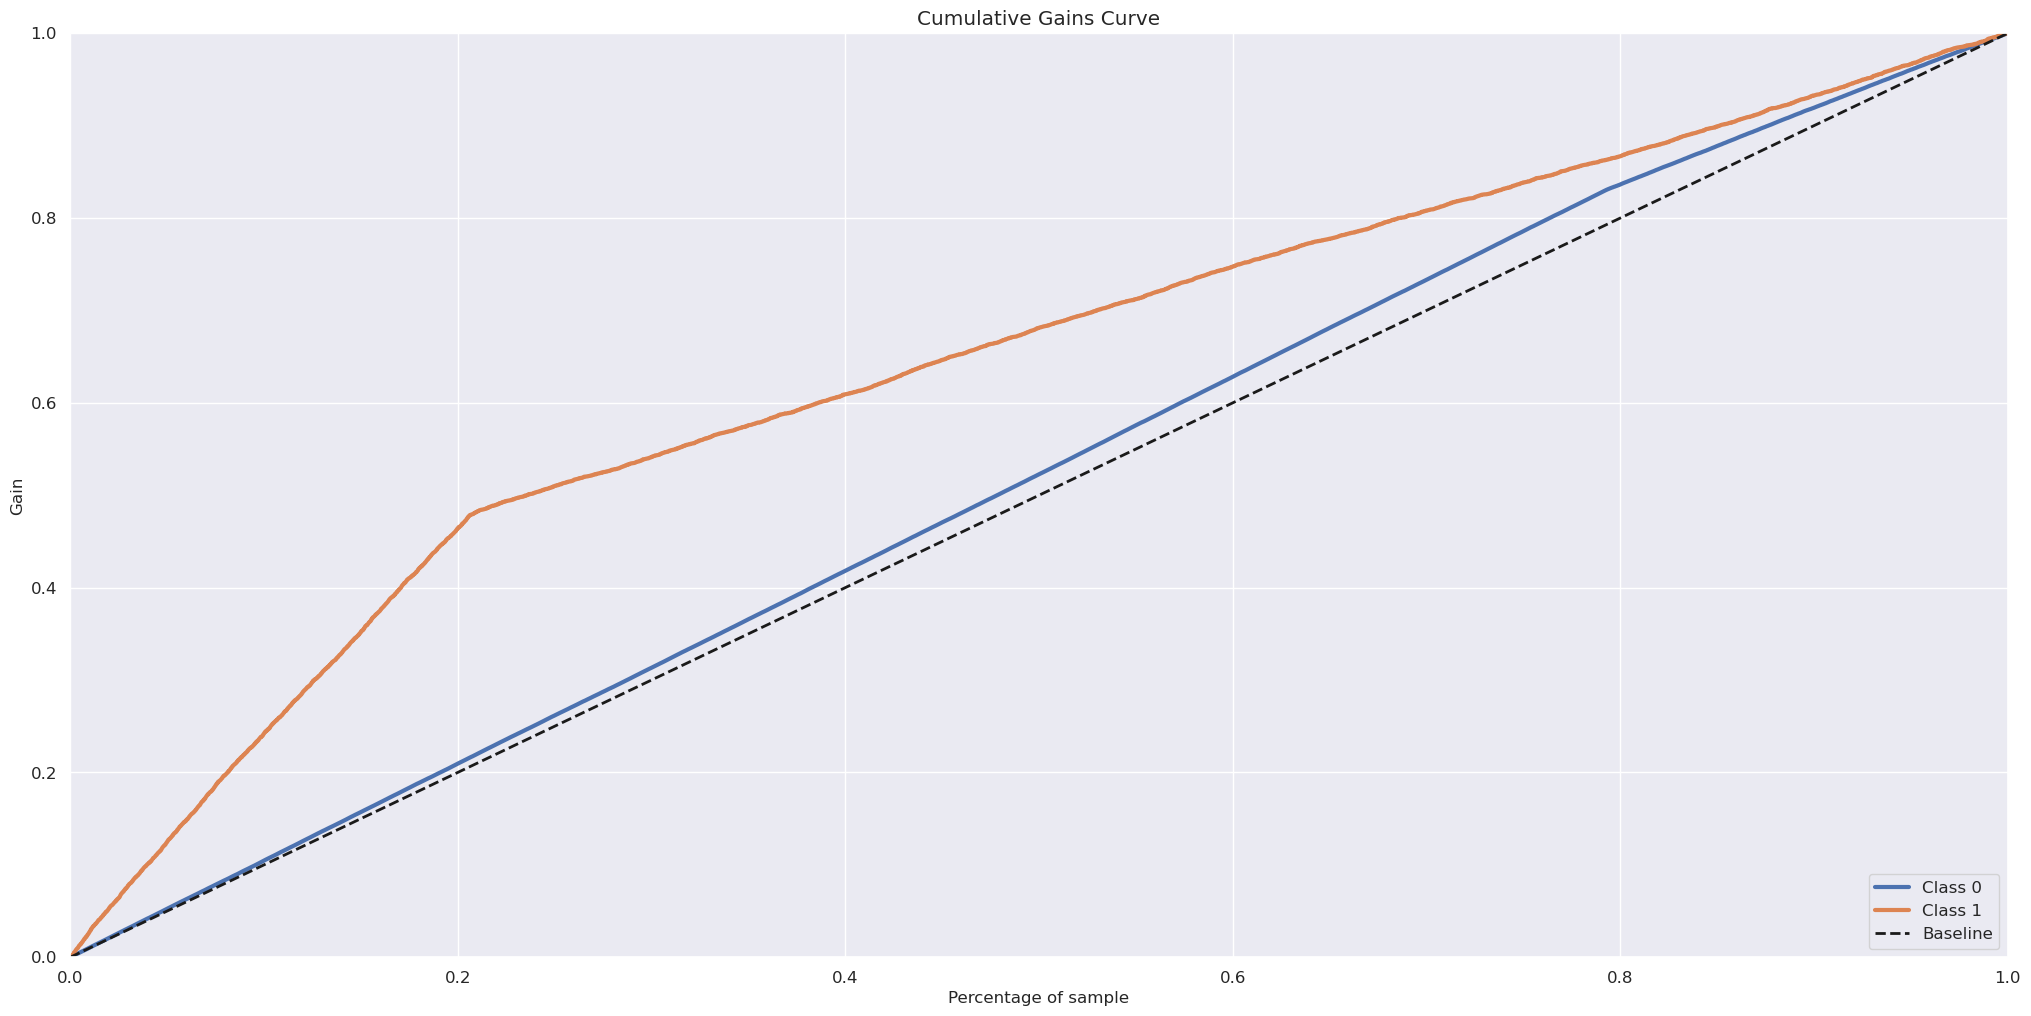

In [27]:
# model 
knn_model = nh.KNeighborsClassifier(n_neighbors = 2)

# model_training
knn_model.fit (x_train,y_train)

# model prediction 
yhat_knn = knn_model.predict_proba (x_val)

# faz metrica pela curva acumulada scikit plot 
skplt.metrics.plot_cumulative_gain(y_val,yhat_knn)

### KNN Model Performance



#### Single Model 

In [31]:
# concat X and y validation
df_aux = X_validation.copy()
df_aux['response'] = y_validation.copy()

# propensity score
df_aux['score'] = yhat_knn[:,1].tolist()

# sort clients by propensity score
df_aux = df_aux.sort_values('score', ascending = False).reset_index(drop=True)

# precision at k
precision_at_100_knn = precision_at_k (df_aux, 100)
print ('Precision at K: {}'.format(precision_at_100_knn))

# recall at k 
recall_at_100_knn = recall_at_k (df_aux,100)
print ('Recall at K: {}'.format(recall_at_100_knn))

Precision at K: 0.31683168316831684
Recall at K: 0.003457216940363008


#### Cross Validation

In [33]:
# instancing the model
knn_model_cv = nh.KNeighborsClassifier(n_neighbors = 2)

# cross-validating
knn_cv = cross_validation ('Knn', knn_model_cv, df7_train)

## Logistic Regression 

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

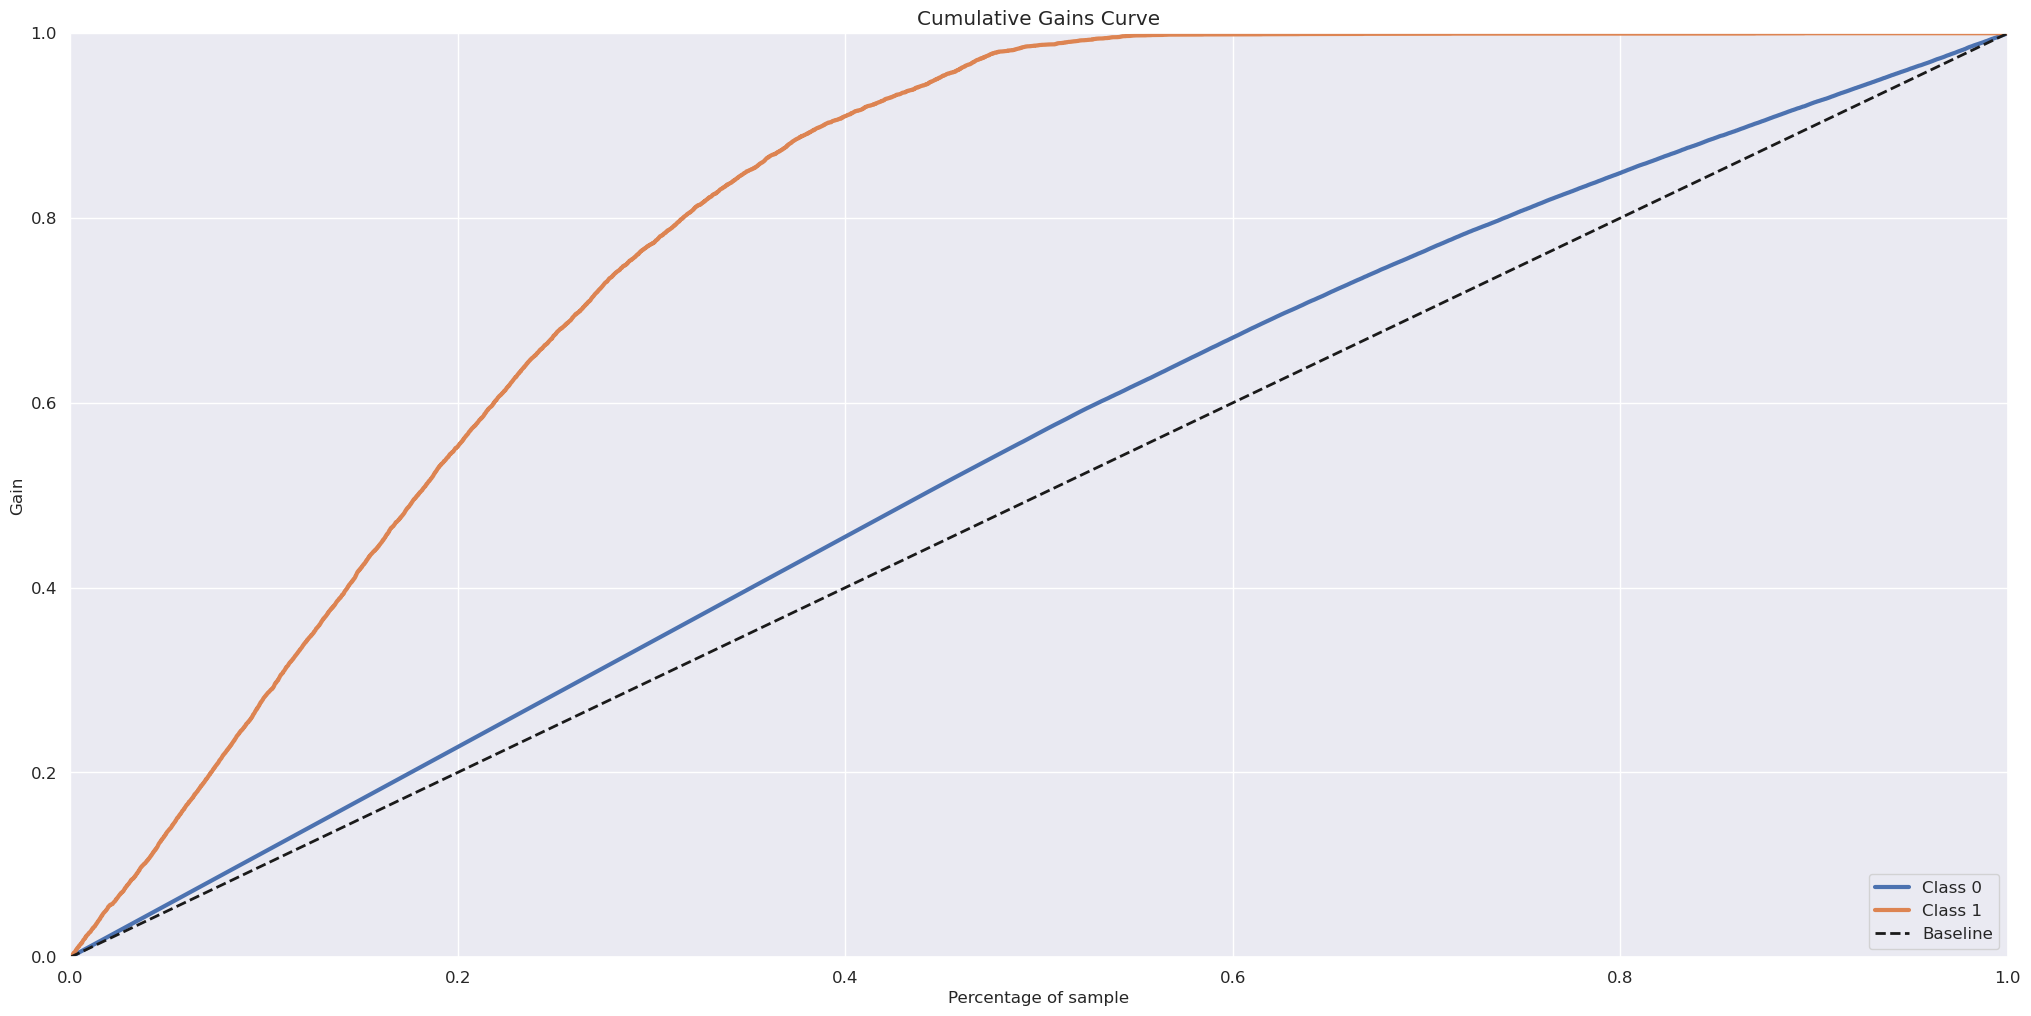

In [34]:
# model 
lr_model = LogisticRegression(random_state=0).fit(x_train,y_train)

# predict 
yhat_lr = lr_model.predict_proba(x_val)

skplt.metrics.plot_cumulative_gain(y_val, yhat_lr )

### Logist Regression Performance

#### Single Performance


In [41]:
# propensity score
df_aux['score'] = yhat_lr[:,1].tolist()

# sort values by score 
df_aux = df_aux.sort_values('score', ascending=False).reset_index(drop=True)

# precision at K
precision_at_100_lr = precision_at_k(df_aux, 100)
print('Precision at K:{}'.format(precision_at_100_lr))

# recall at K 
recall_at_100_lr = recall_at_k(df_aux, 100)
print('Precision at K:{}'.format(recall_at_100_lr))


Precision at K:0.1188118811881188
Precision at K:0.0012964563526361278


#### Cross Validation 

In [36]:
# instancing the model
lr_model_cv = LogisticRegression(random_state=0)

# cross-validating
lr_cv = cross_validation ('LogistRegression', lr_model_cv, df7_train)

## XGBoost Regressor

/home/daniel/miniconda3/envs/health_insurance_cross_sell/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:47:39] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

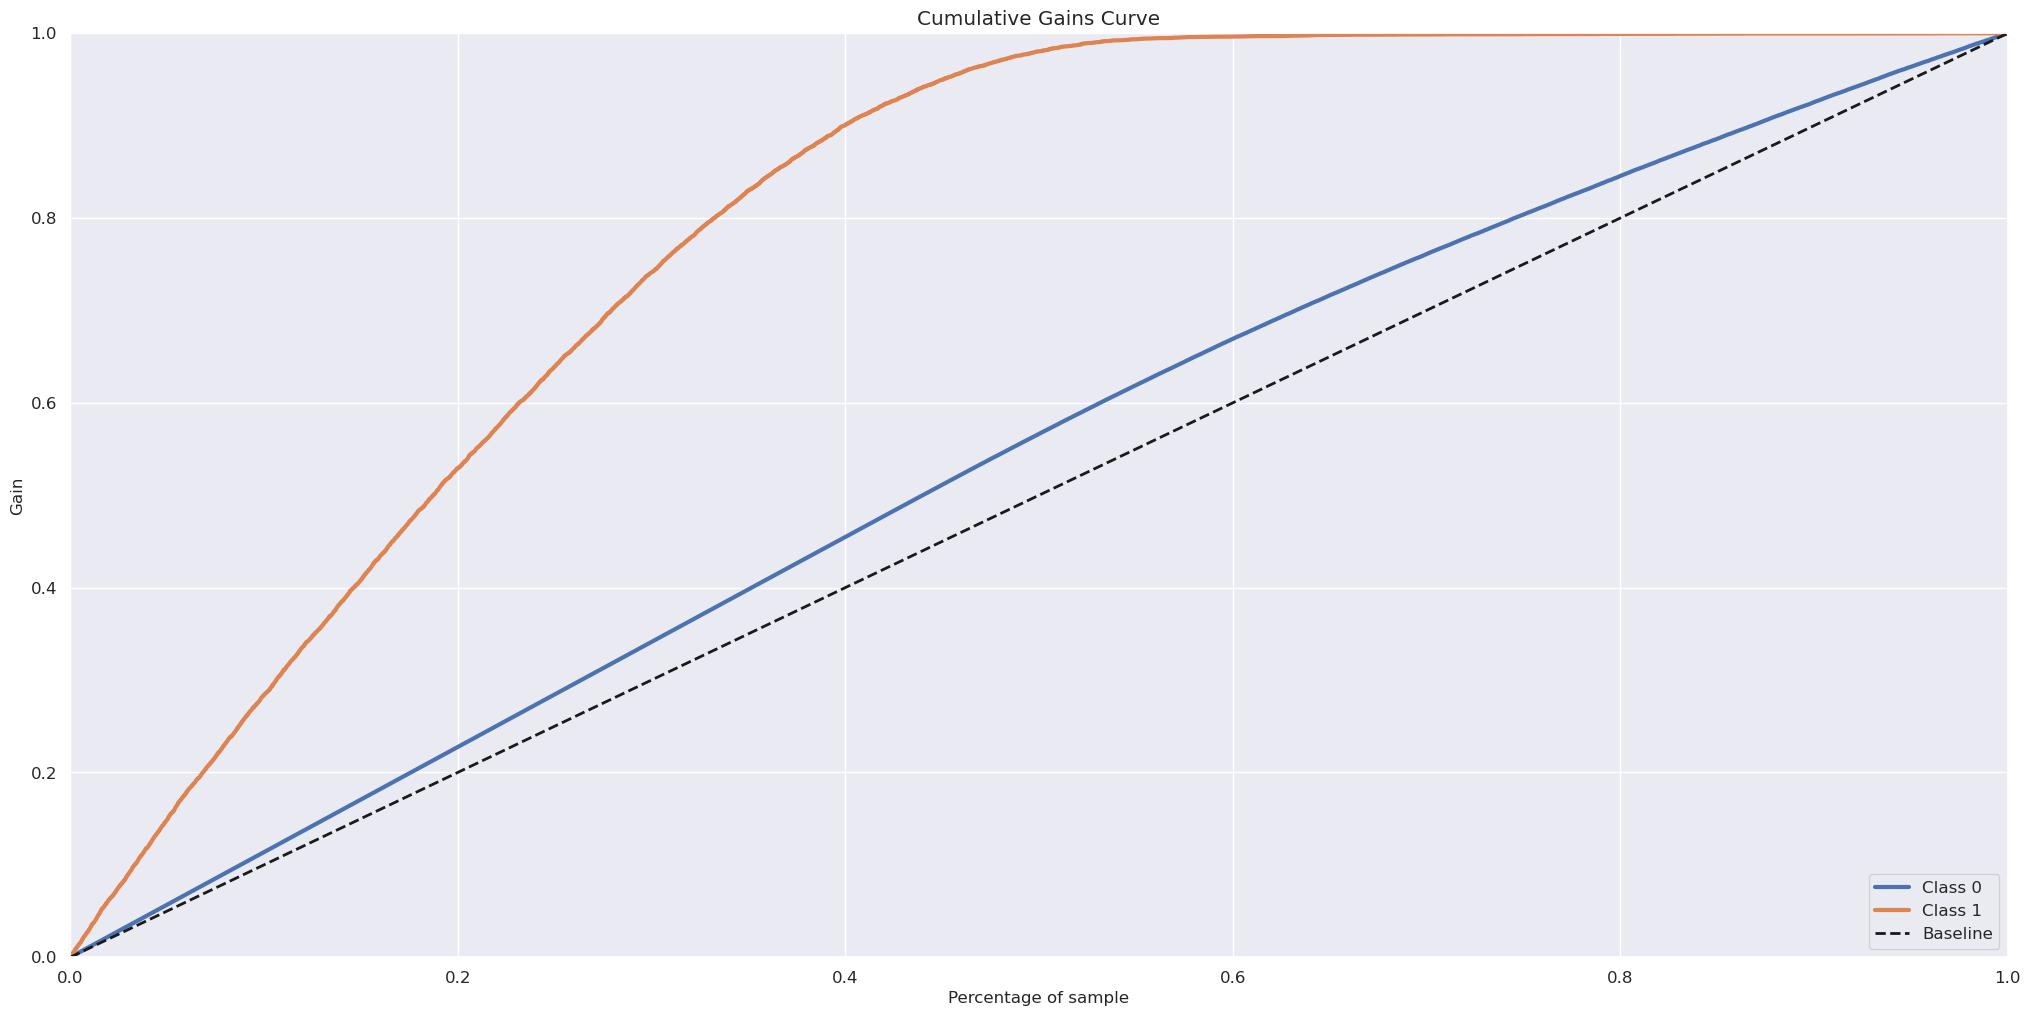

In [37]:
# XGBooster
xgb_model = xgb.XGBClassifier(n_estimators = 2500,
                              max_depth = 5,
                              subsample =0.7,
                              colsample_bytree=0.9,
                             random_state=42).fit(x_train, y_train)

y_hat_xgb = xgb_model.predict_proba(x_val)

skplt.metrics.plot_cumulative_gain(y_val, y_hat_xgb)

### XGBoost Model Performance 

#### Single Performance


In [38]:
# propensity score 
df_aux['score'] = y_hat_xgb[:,1].tolist()

# sort values by score
df_aux = df_aux.sort_values('score', ascending = False).reset_index(drop=True)

In [39]:
# precision at k
precision_at_100_xgb = precision_at_k (df_aux,100)
print('Precision at K:{}'.format(precision_at_100_xgb))


# recall at k 
recall_at_100_xgb = recall_at_k (df_aux,100)
print('Recall at K:{}'.format(recall_at_100_xgb))

Precision at K:0.15841584158415842
Recall at K:0.001728608470181504


#### Cross Validation 

In [40]:
# instancing the model
xgb_model_cv = xgb.XGBClassifier(n_estimators = 2500,
                                 max_depth = 5,
                                 subsample =0.7,
                                 colsample_bytree=0.9,
                                 random_state=42)

# cross-validating
xgb_cv = cross_validation ('XGBoost', knn_model_cv, df7_train)

In [63]:
xgb_cv

,model_name,kfold,precision_at_k,recall_at_k
0,XGBoost,5,0.3426,0.0046


## Comparing models performance

### Single Performance

In [61]:
precision = pd.DataFrame ([[precision_at_100_knn, precision_at_100_lr, precision_at_100_xgb]])
recall = pd.DataFrame ([[recall_at_100_knn, recall_at_100_lr, recall_at_100_xgb]])
single_results = pd.concat([precision, recall]).reset_index()
single_results.columns = ['metrics','knn', 'linear_regression', 'xgboost']
single_results['metrics'] = ['precision@k', 'recall@k']
single_results

,metrics,knn,linear_regression,xgboost
0,precision@k,0.316832,0.118812,0.158416
1,recall@k,0.003457,0.001296,0.001729


### Cross validation performance

In [68]:
final_results = pd.concat([knn_cv, lr_cv, xgb_cv],axis=0)
final_results

,model_name,kfold,precision_at_k,recall_at_k
0,Knn,5,0.3426,0.0046
0,LogistRegression,5,0.3386,0.0046
0,XGBoost,5,0.3426,0.0046


# HIPERPARAMETER FINE TUNING
**Step 8 - CRISP**

In [6]:
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/data/processed/'

df8_train = pd.read_csv (path + 'train.csv')
X_validation = pd.read_csv (path + 'X_validation.csv')
y_validation = pd.read_csv (path + 'y_validation.csv')

In [7]:
X_validation.head()

,id,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,gender_Female,gender_Male
0,74271,0.046154,0.187326,0.188693,1,0.043762,1,0,0.301013,0.069204,0,1
1,15662,0.400000,0.187326,0.200551,1,0.294557,1,0,0.606977,0.173010,0,1
2,233248,0.353846,0.061162,0.200519,1,0.173910,1,0,0.636020,0.166090,0,1
3,140694,0.784615,0.102644,0.188693,1,0.173910,0,1,0.365823,0.038062,0,1
4,43931,0.015385,0.130445,0.028896,1,0.043762,0,1,0.093249,0.557093,1,0


In [8]:
cols_selected = ['vintage',   
'annual_premium',
'age',   
'policy_sales_channel',   
'region_code',    
'vehicle_damage',
'previously_insured',   
]

## Random Search

In [74]:
import random 

In [75]:
# Random Search 

param = {'n_estimators': [1700, 2500, 3000, 3500],
         'eta':[0.01,0.03],
         'max_depth':[3,5,9],
         'subsample' : [0.1, 0.05, 0.7],
         'colsample_bytree': [0.3,0.7,0.9],
        }

MAX_EVAL = 5

In [76]:
# new Dataframe
final = pd.DataFrame()
hp = {}
# iterator to run all key:value of param
for i in range(MAX_EVAL):
    
    xgb_tuned_cv = pd.DataFrame()
    
    # dict comprehension
    hp = { k: random.sample(v,1)[0] for k, v in param.items()}
    print (hp)

    # instancing the model
    xgb_model_tuned = xgb.XGBClassifier(n_estimators = hp['n_estimators'],
                                        max_depth = hp['max_depth'],
                                        eta = hp['eta'],
                                        subsample =hp['subsample'],
                                        colsample_bytree=hp['colsample_bytree'],
                                        random_state=42)

    # cross-validating
    xgb_tuned_cv = cross_validation ('XGBoost Tuned', xgb_model_tuned, df8_train)
    final = pd.concat([final, xgb_tuned_cv],axis=0)
    
    

{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3}


/home/daniel/miniconda3/envs/health_insurance_cross_sell/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:45:27] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/daniel/miniconda3/envs/health_insurance_cross_sell/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:47:37] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/daniel/miniconda3/envs/health_insurance_cross_sell/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:49:46] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/daniel/miniconda3/envs/health_insurance_cross_sell/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:52:06] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/daniel/miniconda3/envs/health_insurance_cross_sell/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:54:26] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.05, 'colsample_bytree': 0.9}


/home/daniel/miniconda3/envs/health_insurance_cross_sell/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:56:50] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/daniel/miniconda3/envs/health_insurance_cross_sell/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:58:50] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/daniel/miniconda3/envs/health_insurance_cross_sell/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:00:32] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/daniel/miniconda3/envs/health_insurance_cross_sell/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:02:09] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/daniel/miniconda3/envs/health_insurance_cross_sell/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:03:47] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3}
[10:05:23] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/daniel/miniconda3/envs/health_insurance_cross_sell/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/daniel/miniconda3/envs/health_insurance_cross_sell/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:07:06] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric i

limit_output extension: Maximum message size of 10000 exceeded with 10042 characters

In [80]:
hp

{'n_estimators': 3000,
 'eta': 0.01,
 'max_depth': 3,
 'subsample': 0.05,
 'colsample_bytree': 0.9}

In [81]:
final

,model_name,kfold,precision_at_k,recall_at_k
0,XGBoost Tuned,5,0.4356,0.0059
0,XGBoost Tuned,5,0.4792,0.0065
0,XGBoost Tuned,5,0.4733,0.0064
0,XGBoost Tuned,5,0.4812,0.0065
0,XGBoost Tuned,5,0.4792,0.0065


## Final Model

In [9]:
param_tuned = {'n_estimators': 3000,
               'eta': 0.01,
               'max_depth': 3,
               'subsample': 0.05,
               'colsample_bytree': 0.9,
                }

/home/daniel/miniconda3/envs/health_insurance_cross_sell/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:48:19] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

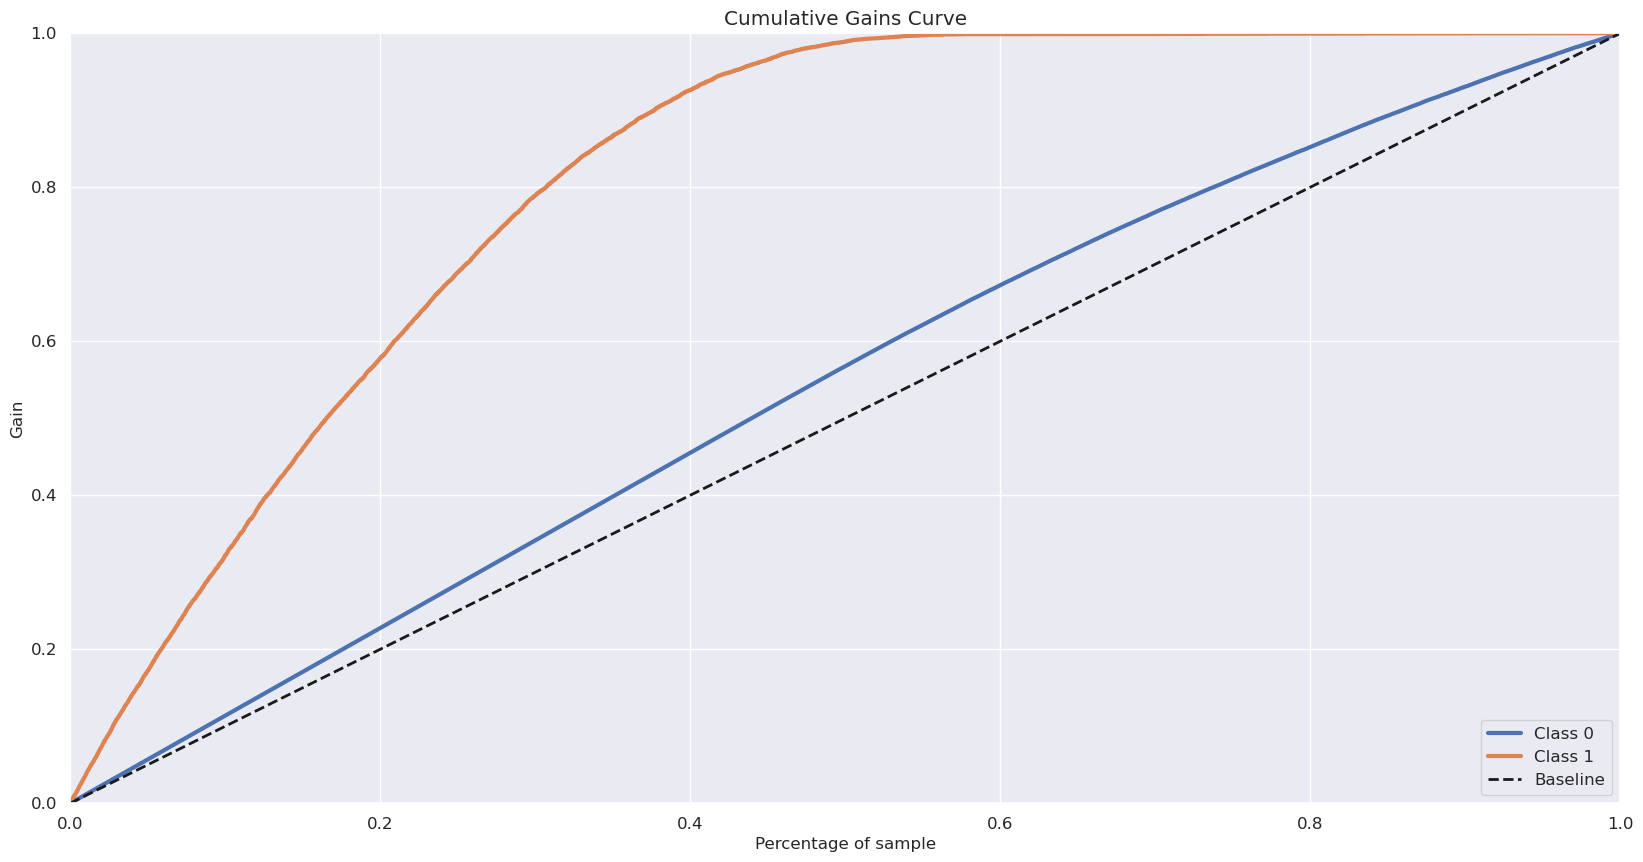

In [10]:
# Split X_train, y_train
X_train = df8_train[cols_selected].values
y_train = df8_train['response'].values
x_val = X_validation[cols_selected].values
y_val = y_validation.values

#Instancing  the model 
xgb_model_tuned = xgb.XGBClassifier(n_estimators = param_tuned['n_estimators'],
                                        eta = param_tuned['eta'],
                                        max_depth = param_tuned['max_depth'],
                                        subsample =param_tuned['subsample'],
                                        colsample_bytree=param_tuned['colsample_bytree'],
                                        random_state=42)

# Fiting the model 
xgb_model_tuned.fit (X_train,y_train)

# Predict Proba
yhat_xgb_model_tuned = xgb_model_tuned.predict_proba (x_val)

# Cumulative gain plot
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb_model_tuned)

In [13]:
# Precision@K and Recall@K
df_aux = pd.concat([X_validation,y_validation], axis = 1)
df_aux['score'] = yhat_xgb_model_tuned[:,1].tolist()
df_aux = df_aux.sort_values('score', ascending= False).reset_index(drop=True)

precision_at_k = precision_at_k(df_aux,14000)
recall_at_k = recall_at_k(df_aux, 14000)
model_name = 'XGBoost'

results = pd.DataFrame([[model_name,precision_at_k,recall_at_k]])
results.columns = ['model_name','precision_at_k','recall_at_k']
results 


,model_name,precision_at_k,recall_at_k
0,XGBoost,0.358046,0.541595


In [14]:
df_aux.head()

,id,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,gender_Female,gender_Male,response,score,ranking,precision_at_k,recall_at_k
0,204143,0.200000,0.123899,0.319085,1,0.17391,1,0,-0.101355,0.799308,0,1,0,0.605749,1,0.000000,0.000000
1,369492,0.215385,0.073493,0.319085,1,0.17391,1,0,-0.171325,0.944637,0,1,1,0.591415,2,0.500000,0.000108
2,187597,0.230769,0.121966,0.319085,1,0.17391,1,0,-0.386798,0.467128,0,1,1,0.589084,3,0.666667,0.000216
3,216400,0.184615,0.130241,0.319085,1,0.17391,1,0,-0.464478,0.027682,1,0,1,0.587814,4,0.750000,0.000324
4,145368,0.169231,0.123899,0.319085,1,0.17391,1,0,-0.134108,0.141869,1,0,1,0.583699,5,0.800000,0.000432


In [31]:
yhat_xgb_model_tuned

array([[7.5111574e-01, 2.4888426e-01],
       [6.4567626e-01, 3.5432374e-01],
       [7.3289090e-01, 2.6710910e-01],
       ...,
       [9.9580985e-01, 4.1901194e-03],
       [9.9938262e-01, 6.1736273e-04],
       [9.1235095e-01, 8.7649040e-02]], dtype=float32)

In [40]:
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/data/interim/'

df_aux.to_csv(path + 'fine_tuned_error_measures.csv', index=False)

# yhat_xgb_model_tuned to csv 
df_probas = pd.DataFrame(yhat_xgb_model_tuned)

df_probas.to_csv(path + 'fine_tuned_yhat_proba.csv', index=False)

# ERROR TRADUCTION AND INTERPRETATION
**Step 9 - CRISP**

In [48]:
# Load data
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/data/'

df9 = pd.read_csv (path + 'interim/fine_tuned_error_measures.csv')
yhat = pd.read_csv(path + 'interim/fine_tuned_yhat_proba.csv').values
y_val = pd.read_csv (path + 'processed/y_validation.csv').values

In [95]:
print('Total of customers at validation dataset: {}'.format(df9['ranking'].max()))
print('Total of customers interested in car insurance: {}'.format(df9['response'].sum()))

Total of customers at validation dataset: 76222
Total of customers interested in car insurance: 9256


The lift curve below show us how many times the rate of this model is above a random choice. For example, at baseline model, selecting 20% of customers from the base is expected to find 20% of total customers who are interested, i.e. 1851 customers (9256 * 20%). On other hand, selecting the first 20% of customers of a list ordered by the model, it is expected to find 5349 customers interested, i.e. 57,8% of total customers interested



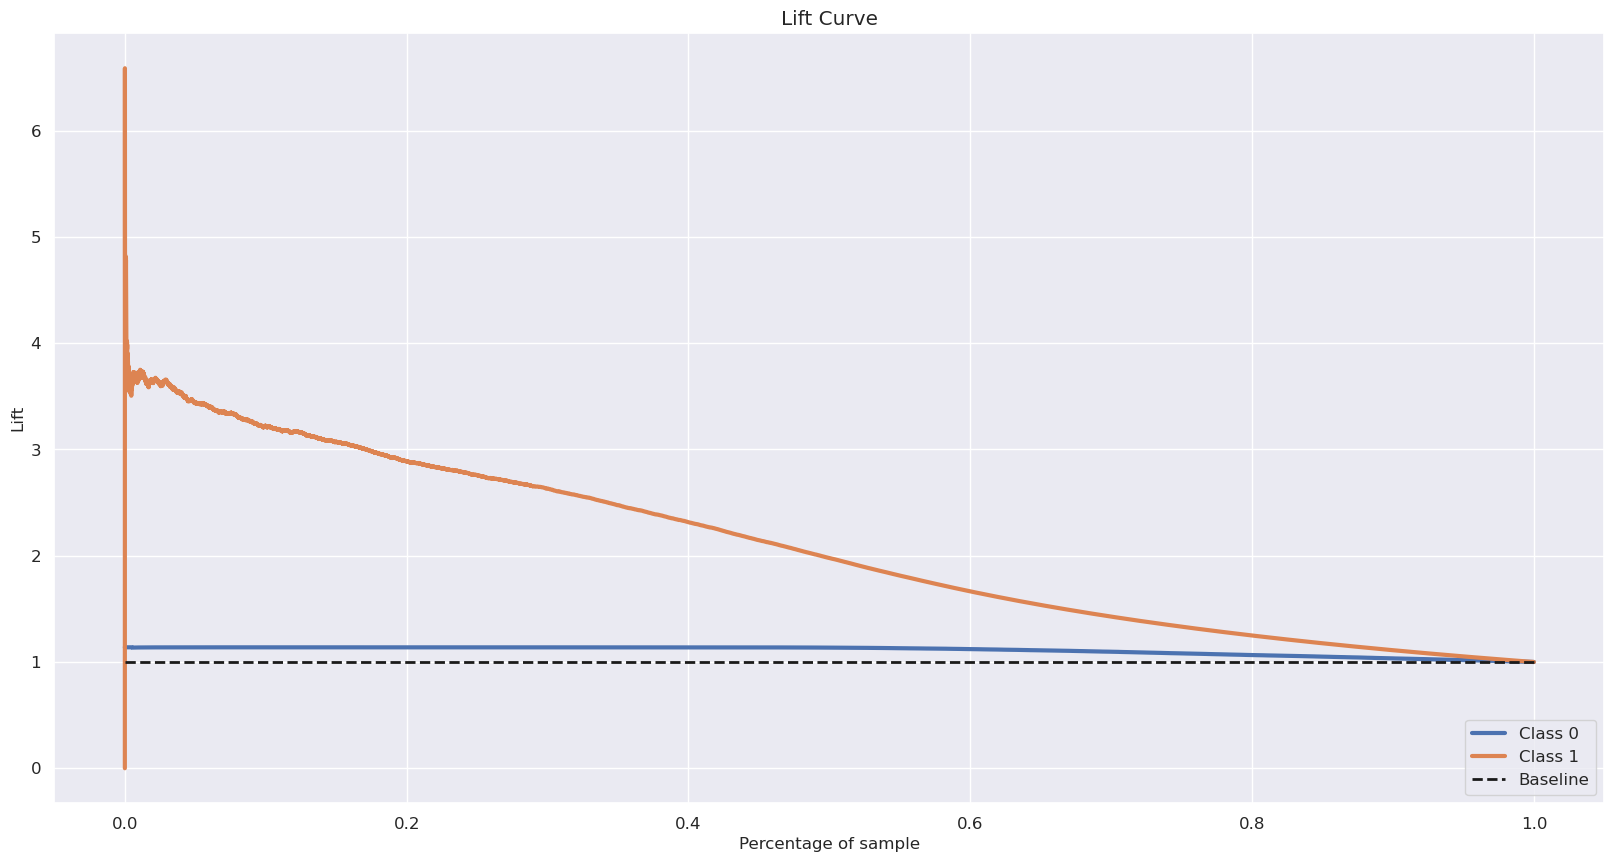

In [64]:
skplt.metrics.plot_lift_curve(y_val,yhat);

In [98]:
# Calculating the lift values for each position 
df9['baseline_model'] = df9['ranking']/df9.shape[0] #as the same, of calculating the data divided per total of rows. Represents the rate of conversion of random model 

df9['lift'] = df9['recall_at_k'] / df9['baseline_model']

# Filtering for decil
quantis = [round(q) for q in quantiles (df9['ranking'], n=10)]

df_aux = df9.loc[:, ['ranking','recall_at_k','baseline_model','lift','response']]
df_aux['quantil'] = df_aux['ranking'].apply(lambda x: '10' if x == 7622 else '20' if x == 15245 else '30' if x == 22867 else '40' if x == 30489 else '50' if x == 38112 else
                                                      '60' if x == 45734 else '70' if x == 53356 else '80' if x == 60978 else '90' if x == 68601 else 0)

# Reduction per 1000 at cost of acquisition of customer 
df_aux['interested_by_model'] = df_aux['response'].cumsum()
df_aux['interested_baseline'] = df_aux['baseline_model'] * df_aux['response'].sum() 
df_aux['cost_reduction_factor_per_1000'] = 1000*(df_aux['interested_baseline']-df_aux['interested_by_model'])/(df_aux['interested_by_model']*df_aux['interested_baseline'])

df_aux = np.round(df_aux.loc[(df_aux['quantil'] != 0), ['quantil','ranking','lift','interested_by_model', 'interested_baseline','cost_reduction_factor_per_1000']],2).reset_index(drop=True)
df_aux

,quantil,ranking,lift,interested_by_model,interested_baseline,cost_acquisition_reduction_factor
0,10,7622,3.22,2980,925.58,-0.74
1,20,15245,2.89,5349,1851.27,-0.35
2,30,22867,2.63,7305,2776.85,-0.22
3,40,30489,2.32,8573,3702.42,-0.15
4,50,38112,1.98,9155,4628.12,-0.11
5,60,45734,1.66,9245,5553.70,-0.07
6,70,53356,1.43,9246,6479.27,-0.05
7,80,60978,1.25,9251,7404.85,-0.03
8,90,68601,1.11,9254,8330.55,-0.01


Since the customer acquisition cost is the total amount of money spent on the total number of customers acquired, it was possible to calculate the reduction of this cost given by the model, as a reduction factor (per 1000). 

# DEPLOY MODEL TO PRODUCTION
**Step 10 - CRISP**

In [59]:
# Save trained model 
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/health_insurance_app/model/'
pickle.dump(xgb_model_tuned, open(path + 'healthinsurance.pkl', 'wb'))

## Health Insurance Class

In [69]:
import pickle
import pandas as pd 
import inflection

class HealthInsurance: 
    
    def __init__(self):
        
        # project home_path
        self.home_path = '/home/daniel/repos/pa04_health_insurance_cross_sell/'
        
        # load scalers and encoders from pickle
        self.annual_premium_scaler = pickle.load (open (self.home_path + 'health_insurance_app/features/annual_premium_scaler.pkl','rb'))
        
        self.age_scaler =  pickle.load (open (self.home_path + 'health_insurance_app/features/age_scaler.pkl','rb'))
        
        self.vintage_scaler = pickle.load (open (self.home_path + 'health_insurance_app/features/vintage_scaler.pkl','rb'))
        
        self.region_code_scaler = pickle.load (open (self.home_path + 'health_insurance_app/features/region_code_scaler.pkl','rb'))
        
        self.policy_sales_channel_scaler = pickle.load (open (self.home_path + 'health_insurance_app/features/policy_sales_channel_scaler.pkl','rb'))
        
        self.vehicle_age_scaler = pickle.load (open (self.home_path + 'health_insurance_app/features/vehicle_age_scaler.pkl','rb'))
        
        
        
    def data_cleaning ( self, data ): 
        
        # change dtypes
        data['region_code'] = data['region_code'].astype('int64')
        data['policy_sales_channel'] = data['policy_sales_channel'].astype('int64')    

        return data

    
    
    def feature_engineering (self,  data ):
    
        data['vehicle_damage'] = data['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        
        return data

    
    
    def data_preparation ( self, data): 
        
        # Standard Scaler
        data['annual_premium'] = self.annual_premium_scaler.transform(data[['annual_premium']].values)
        
        
        # MinMaxScaler
        # 'age'
        data[['age']] = self.age_scaler.transform (data[['age']].values)

        # 'vintage'
        data[['vintage']] = self.vintage_scaler.transform (data[['vintage']].values)
        
        
        # One Hot Encoder
        # 'gender'
        data = pd.get_dummies(data=data, columns = ['gender'], prefix='gender')

        # Target Encoder 
        # 'region_code'
        data.loc[:,'region_code'] = data['region_code'].map(self.region_code_scaler)

        # 'policy_sales_channel'
        data.loc[:,'policy_sales_channel'] = data['policy_sales_channel'].map(self.policy_sales_channel_scaler)

        # 'vehicle_age'
        data.loc[:,'vehicle_age'] = data['vehicle_age'].map(self.vehicle_age_scaler)


        # Feature Selection
        cols_selected = ['vintage',   
                         'annual_premium',
                         'age',   
                         'policy_sales_channel',   
                         'region_code',    
                         'vehicle_damage',
                         'previously_insured',   
                        ]
        
        return data[cols_selected]
        
        
        
    def prediction_proba ( self, model, data, data_raw):        

        # Predict Proba
        score = model.predict_proba (data)

        # add predictions to data_raw
        data_raw['score'] = score[:,1].tolist()
        
        return data_raw.to_json (orient = 'records')

       

### Testing HealthInsurance Class

In [66]:
# Load validation dataset before preprocessing
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/data/interim/'
df_validation = pd.read_csv(path + 'validation_splited.csv')

# Get a sample of 30 rows
df_validation = df_validation.sample(30)

# Split X,y
X_validation = df_validation.drop(columns = ['response'],axis=1)
y_validation = df_validation['response']

In [73]:
# Testing HealthInsurance()
model = HealthInsurance()

df1_ = model.data_cleaning (df_validation)

df2_ = model.feature_engineering(df1_)

df3_ = model.data_preparation(df2_)

modeling = pickle.load(open('/home/daniel/repos/pa04_health_insurance_cross_sell/health_insurance_app/model/healthinsurance.pkl', 'rb'))

df4_ = model.prediction_proba (modeling,df3_, df_validation)

df4_

/tmp/ipykernel_15644/2428189292.py:71: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'vehicle_age'] = data['vehicle_age'].map(self.vehicle_age_scaler)


'[{"id":328444,"gender":"Male","age":-0.3124223942,"region_code":11,"policy_sales_channel":154,"driving_license":1,"vehicle_age":"< 1 Year","vehicle_damage":0,"previously_insured":0,"annual_premium":-1.7745808915,"vintage":-0.0347190307,"response":0,"score":0.1161674783},{"id":281084,"gender":"Male","age":-0.3124187528,"region_code":22,"policy_sales_channel":160,"driving_license":1,"vehicle_age":"< 1 Year","vehicle_damage":0,"previously_insured":1,"annual_premium":-1.7745808969,"vintage":-0.0347156335,"response":0,"score":0.0021639245},{"id":197754,"gender":"Male","age":-0.3123786982,"region_code":29,"policy_sales_channel":152,"driving_license":1,"vehicle_age":"< 1 Year","vehicle_damage":0,"previously_insured":1,"annual_premium":-1.774580891,"vintage":-0.0347202736,"response":0,"score":0.0017984804},{"id":290801,"gender":"Male","age":-0.3123313609,"region_code":35,"policy_sales_channel":124,"driving_license":1,"vehicle_age":"1-2 Year","vehicle_damage":0,"previously_insured":0,"annual_p

## API Handler

In [79]:
import pickle 
from flask import Flask, request, Response 
import pandas as pd
from health_insurance.HealthInsurance import HealthInsurance

#loading the model 
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/health_insurance_app/model/'
model = pickle.load(open(path + 'healthinsurance.pkl', 'rb'))

app = Flask ( __name__ )

@app.route ('/predict', methods = ['POST'])
def health_insurance_cross_sell ():
    test_json = request.get_json ()
    
    if test_json:
        if isinstance (test_json, dict):
            data_raw = pd.DataFrame (test_json, index=[0])
            
        else: 
            data_raw = pd.DataFrame (test_json, columns = test_json[0].keys())
            
        # Instantiate HealthInsurance
        pipeline = HealthInsurance()

        df1 = pipeline.data_cleaning (data_raw)

        df2 = pipeline.feature_engineering (df1)

        df3 = pipeline.data_preparation (df2)

        df_response = pipeline.prediction_proba (model, df3, data_raw)

        return df_response

    else:
        Response ('{}', status = 200, mimetype='application/json')
        
        
if __name__ == "__main__":
    app.run ('0.0.0.0')#,debug=True)



    

 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.


AssertionError: 

## API Tester

In [3]:
# Load validation dataset before preprocessing
path = '/home/daniel/repos/pa04_health_insurance_cross_sell/data/interim/'
df_validation = pd.read_csv(path + 'validation_splited.csv')

# Get a sample of 30 rows
df_validation = df_validation.sample(30)

# Split X,y
X_validation = df_validation.drop(columns = ['response'],axis=1)
y_validation = df_validation['response']

In [4]:
# Converting to json format to call handler with method 'POST'
data = json.dumps(X_validation.to_dict(orient='records'))
data

'[{"id": 239128, "gender": "Male", "age": 56, "region_code": 5, "policy_sales_channel": 26, "driving_license": 1, "vehicle_age": "1-2 Year", "vehicle_damage": 1, "previously_insured": 0, "annual_premium": 35105.0, "vintage": 39}, {"id": 294400, "gender": "Male", "age": 22, "region_code": 8, "policy_sales_channel": 160, "driving_license": 1, "vehicle_age": "< 1 Year", "vehicle_damage": 0, "previously_insured": 0, "annual_premium": 35949.0, "vintage": 119}, {"id": 230416, "gender": "Male", "age": 23, "region_code": 5, "policy_sales_channel": 152, "driving_license": 1, "vehicle_age": "< 1 Year", "vehicle_damage": 1, "previously_insured": 0, "annual_premium": 33897.0, "vintage": 278}, {"id": 43541, "gender": "Male", "age": 33, "region_code": 29, "policy_sales_channel": 156, "driving_license": 1, "vehicle_age": "1-2 Year", "vehicle_damage": 1, "previously_insured": 0, "annual_premium": 2630.0, "vintage": 206}, {"id": 200245, "gender": "Male", "age": 31, "region_code": 3, "policy_sales_chann

In [8]:
# API Call
# url = 'http://0.0.0.0:5000/predict' # this endpoint call handler.py
url = 'https://app-health-insurance-predict.onrender.com/predict'

header=  {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data,headers=header)
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200
